In [184]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from pandas import DataFrame, Series
import matplotlib.pylab as plt
import seaborn as sns 
import pandas as pd
import numpy as np
import datetime
import os
import io

%matplotlib inline
np.set_printoptions(precision=3 , suppress= True)

In [134]:
#initial parameters - name and path
station_names = ['acom', 'barc', 'brse', 'cafv', 'canv', 
                 'citt', 'kope', 'koe2', 'mogg', 'mpra', 
                 'odez', 'pord', 'port', 'rovr', 'sapp',
                 'tarv', 'trie', 'trvs'
                ]
folder_path = '/home/rafaela/internship/time_series/Time-Series-Analysis/Cansiglio Plateau + Classical Karst/'

In [135]:
def import_station_data(station_name, folder_path, file_format='txt'):
    
    #joining the folder path with the name of the station to get all the wanted ones
    file_path = os.path.join(folder_path, f'{station_name}.{file_format}')
    
    #selecting the name of the columns that will be used to do the analysis
    columns_name = ['YYMMMDD', '__east(m)']
    
    #checking the file format and sending an error message if the format doesn't match
    if file_format == 'txt':
        station_data = pd.read_csv(file_path, usecols=columns_name, delimiter='\s+')
    else:
        raise ValueError (f'{file_format}: unsupported file format.')
    
    
    try:
        #initial setting as datetime format, index, column names and time period
        station_data['YYMMMDD'] = pd.to_datetime(station_data['YYMMMDD'], format='%y%b%d', errors='coerce')
        station_data.set_index('YYMMMDD', inplace = True)
        station_data = station_data.rename(columns={'__east(m)':f'{station_name}_east(m)'})
        station_data = station_data.loc['2011-01-15':'2018-07-15']
        
    except ValueError as e:
        print(f"Erro to import {station_name}: {e}")
        station_data = None
    
    return station_data

#dictionaries to store the data
station_data_dict = {}

#calling the function
for station_name in station_names:
    station_data = import_station_data(station_name, folder_path, file_format='txt')
    station_data_dict[station_name] = station_data

#printing dataframe
#stations
#for station_name, station_data in station_data_dict.items():
    #print(f'{station_name.upper()}:\n{station_data}\n')

In [177]:
def linear_detrend(station_data, station_name):
 
    #getting the linear model to substract from the original time series:
    x = np.arange(len(station_data)).reshape(-1, 1)
    y = station_data[f'{station_name}_east(m)'].values.reshape(-1, 1)
    
    linear_model = LinearRegression().fit(x, y)
    regression_line = linear_model.predict(x)
    
    detrended_values = y.flatten() - regression_line.flatten()
    #detrended_values = station_data[f'{station_name}_east(m)'].values - regression_line.flatten()
    
    detrended_dataframe = pd.DataFrame(detrended_values, index=station_data.index, columns=[f'{station_name}_east(m)_detrended'])
    
    return detrended_dataframe


#dictionaries to store the data
detrended_data_dict = {}

#calling the function
for station_name, station_data in station_data_dict.items():
    detrended_dataframe = linear_detrend(station_data, station_name)
    detrended_data_dict[station_name] = detrended_dataframe

#printing dataframe
#stations detrended
#for station_name, station_data in detrended_data_dict.items():
    #print(f'{station_name.upper()}: \n{station_data}\n')
    

In [213]:
def remove_outliers(station_data, station_name):
    limiar_z = 3.0
    
    
    selecting_outliers = station_data[(np.abs(station_data-station_data.mean()) 
                                              < limiar_z*station_data.std())]
    
    
    outliers_removed_dataframe = pd.DataFrame(selecting_outliers, 
                                              index=station_data.index)
    
    outliers_removed_dataframe = outliers_removed_dataframe.rename(
        columns={f'{station_name}_east(m)_detrended':f'{station_name}_east(m)'})  
    
    outliers_removed_dataframe.dropna(inplace=True)
    
    return outliers_removed_dataframe

#dictionaries to store the data
stations_outliers_removed_dict = {}

#calling the function
for station_name, station_data in detrended_data_dict.items():
    outliers_removed_dataframe = remove_outliers(station_data, station_name)
    stations_outliers_removed_dict[station_name] = outliers_removed_dataframe

#printing dataframe
#stations detrended
#for station_name, station_data in stations_outliers_removed_dict.items():
    #print(f'{station_name.upper()}: \n{station_data}\n')
    

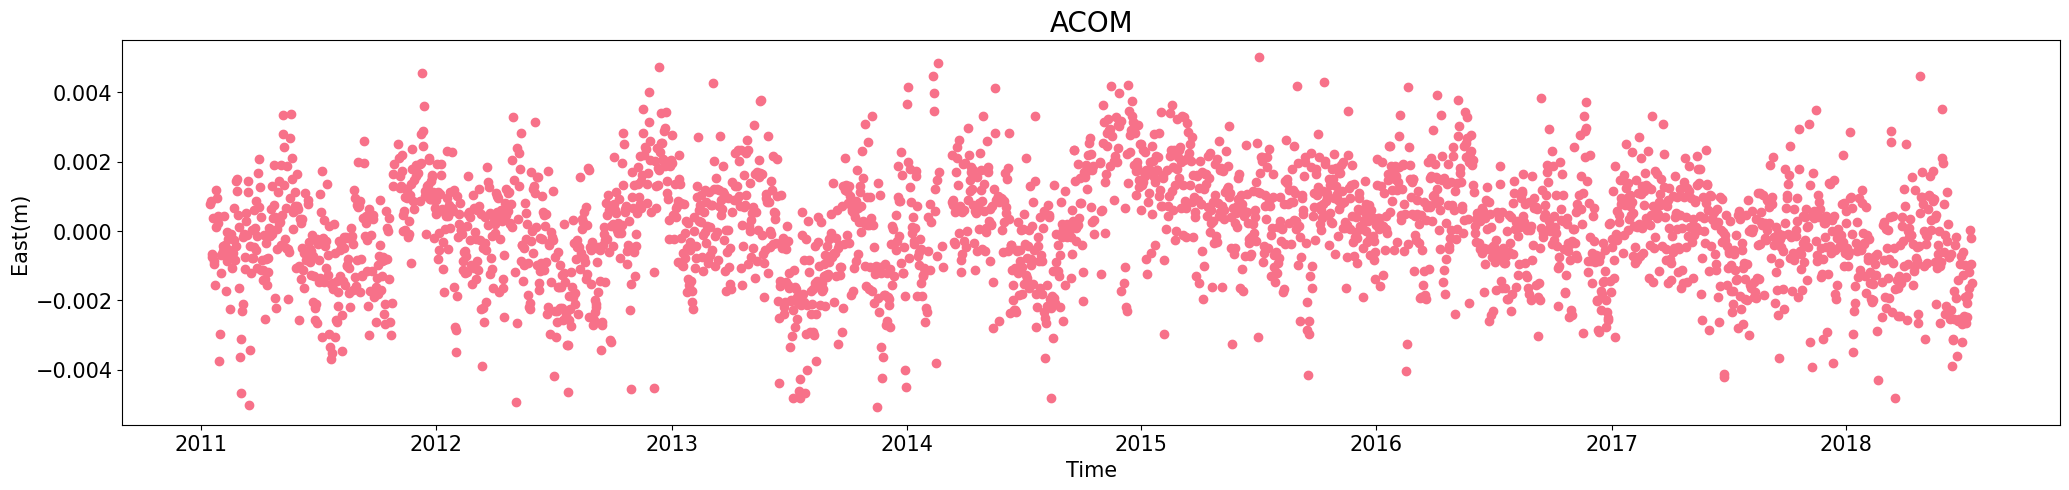

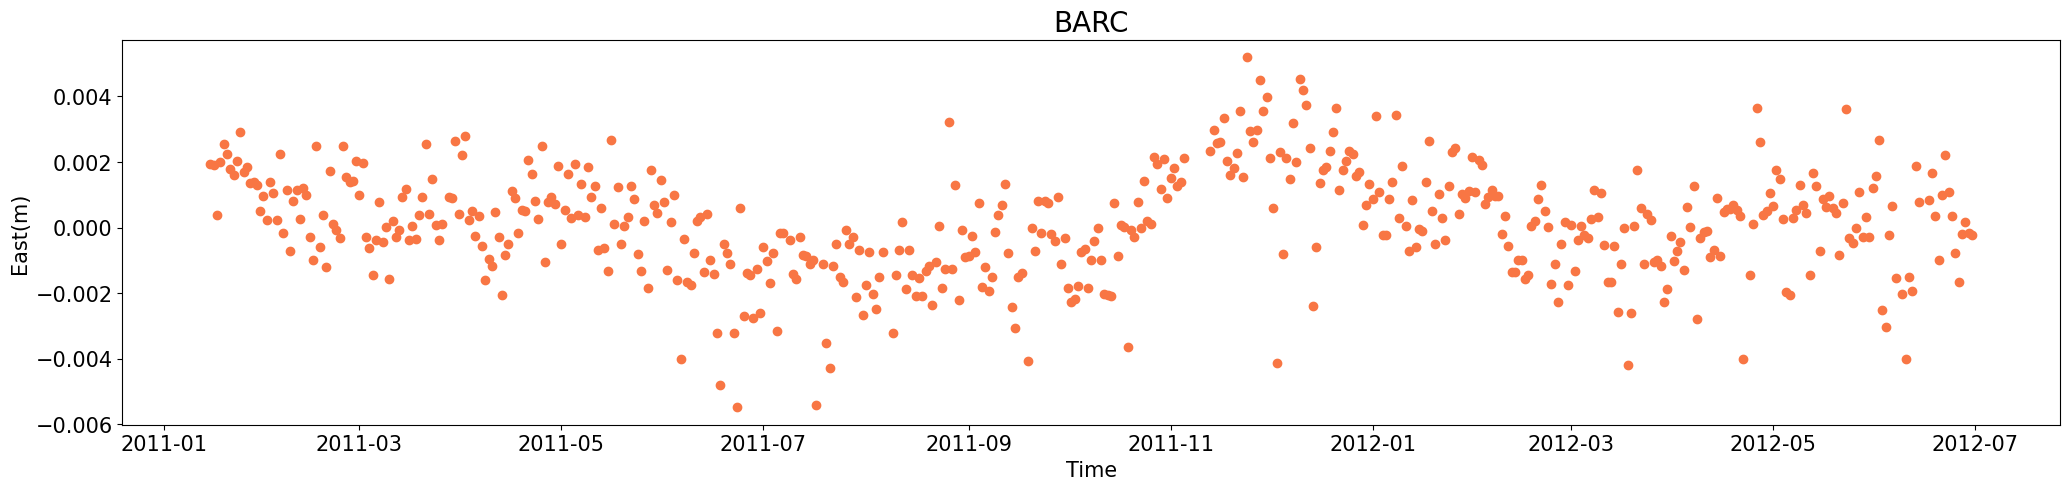

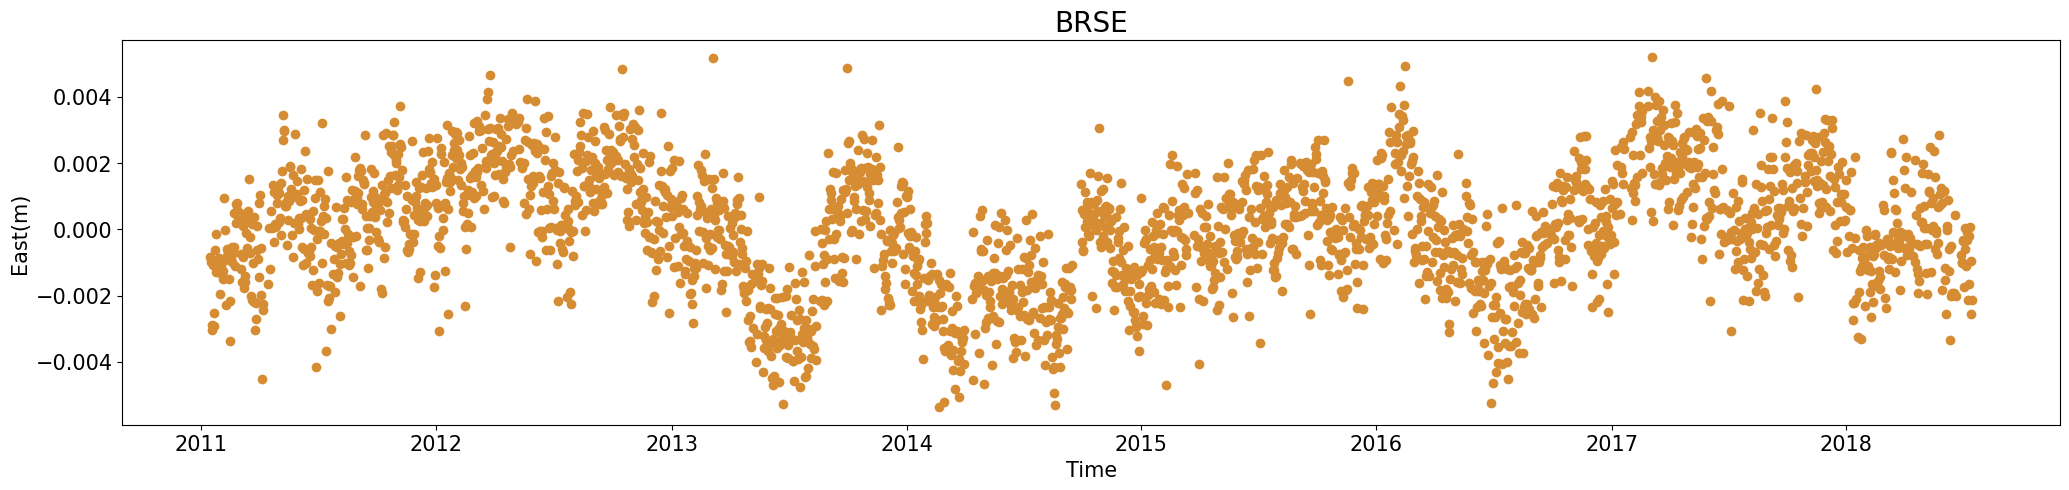

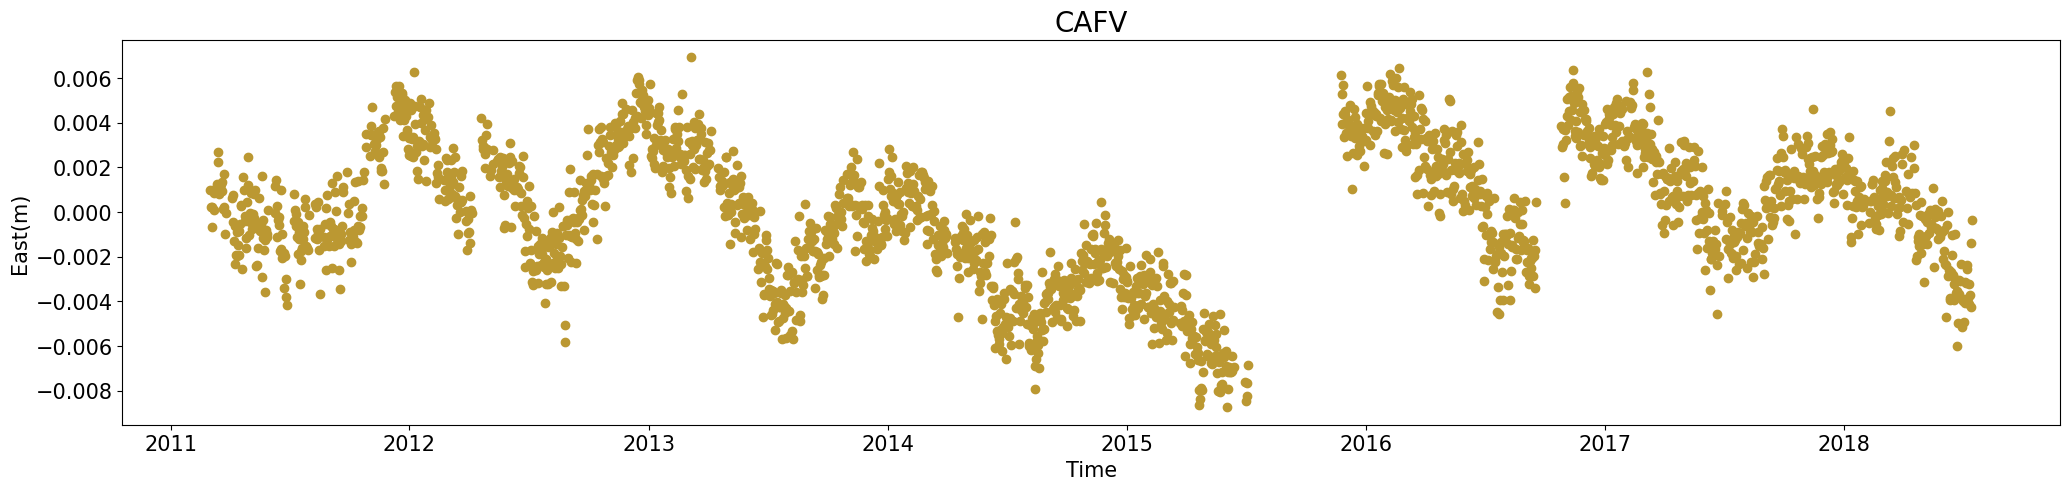

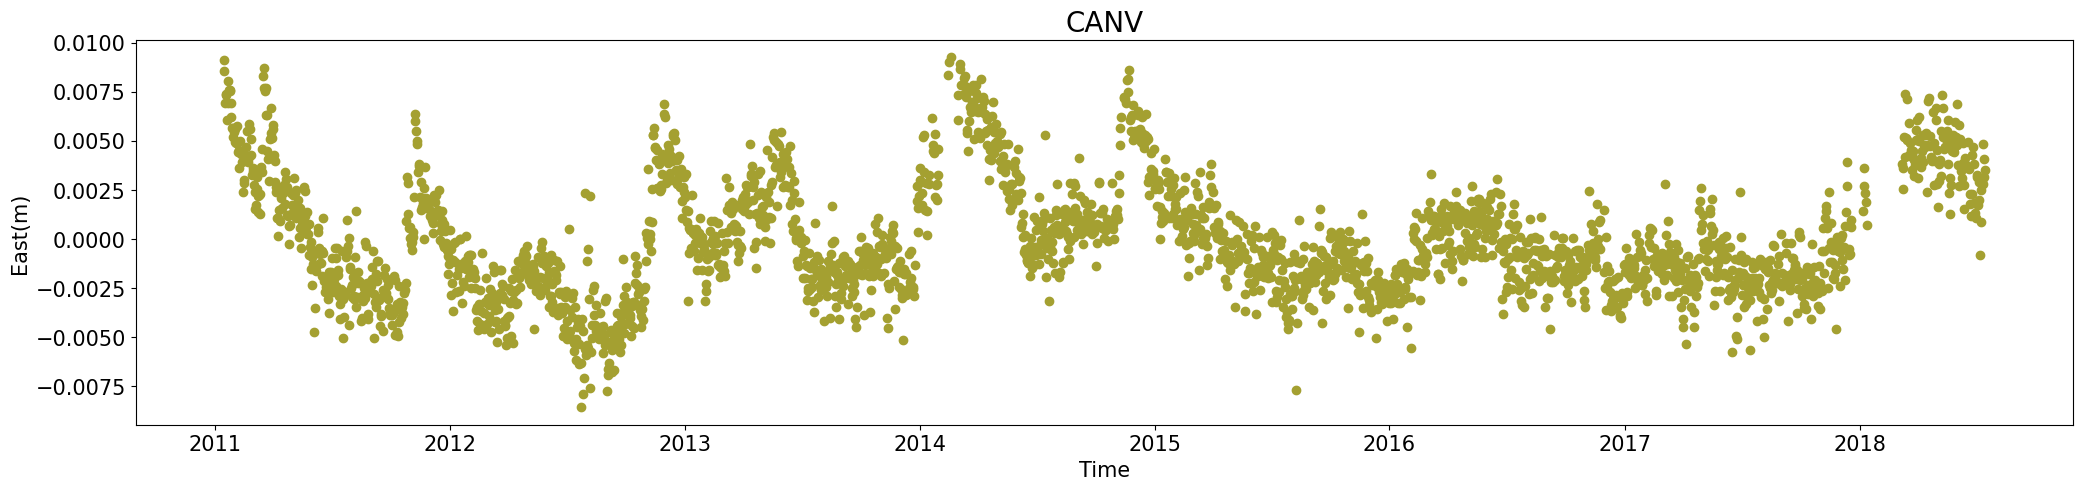

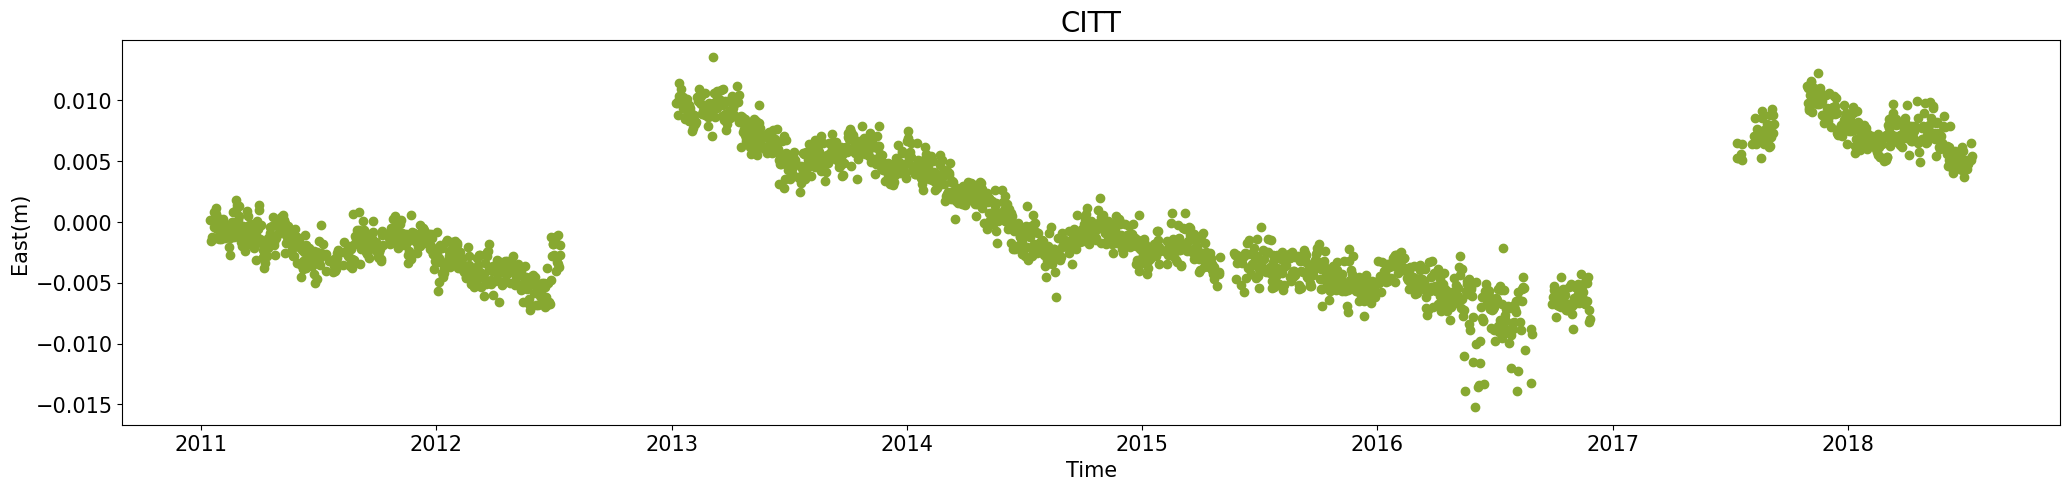

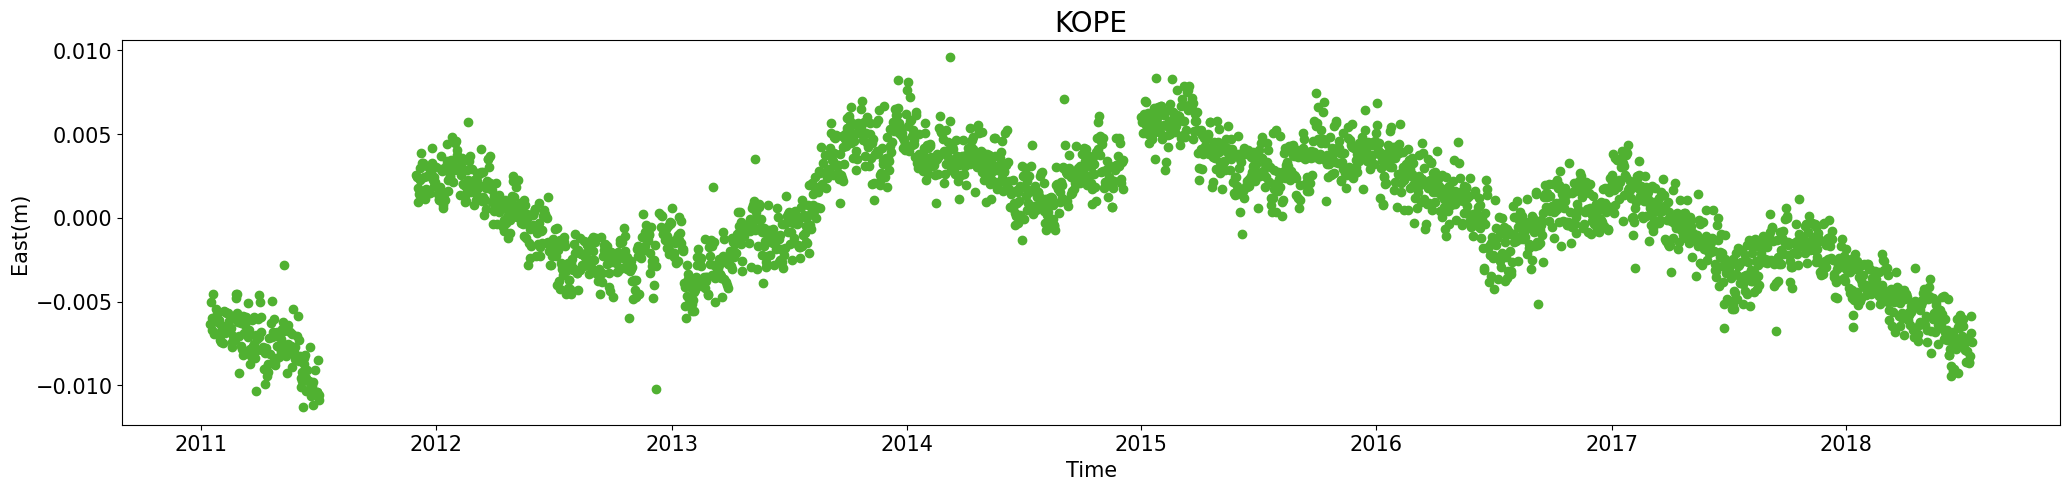

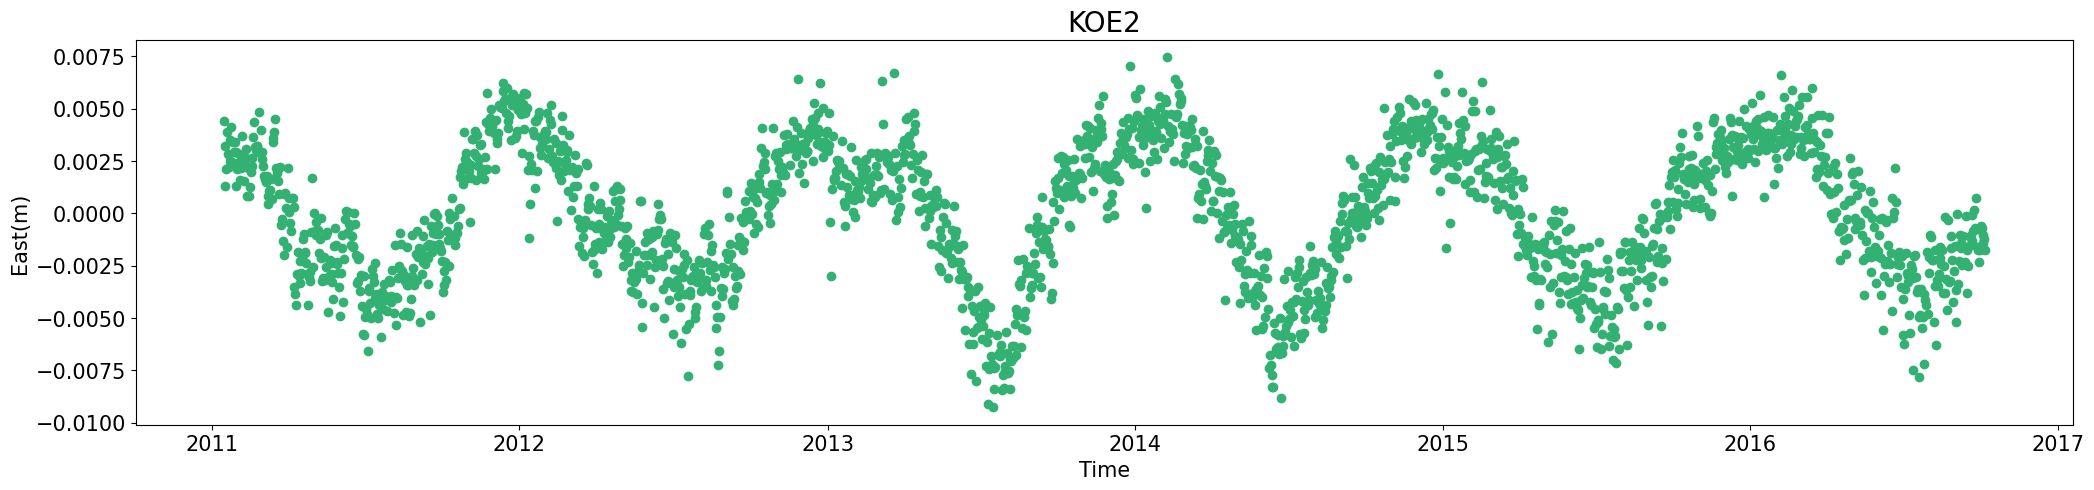

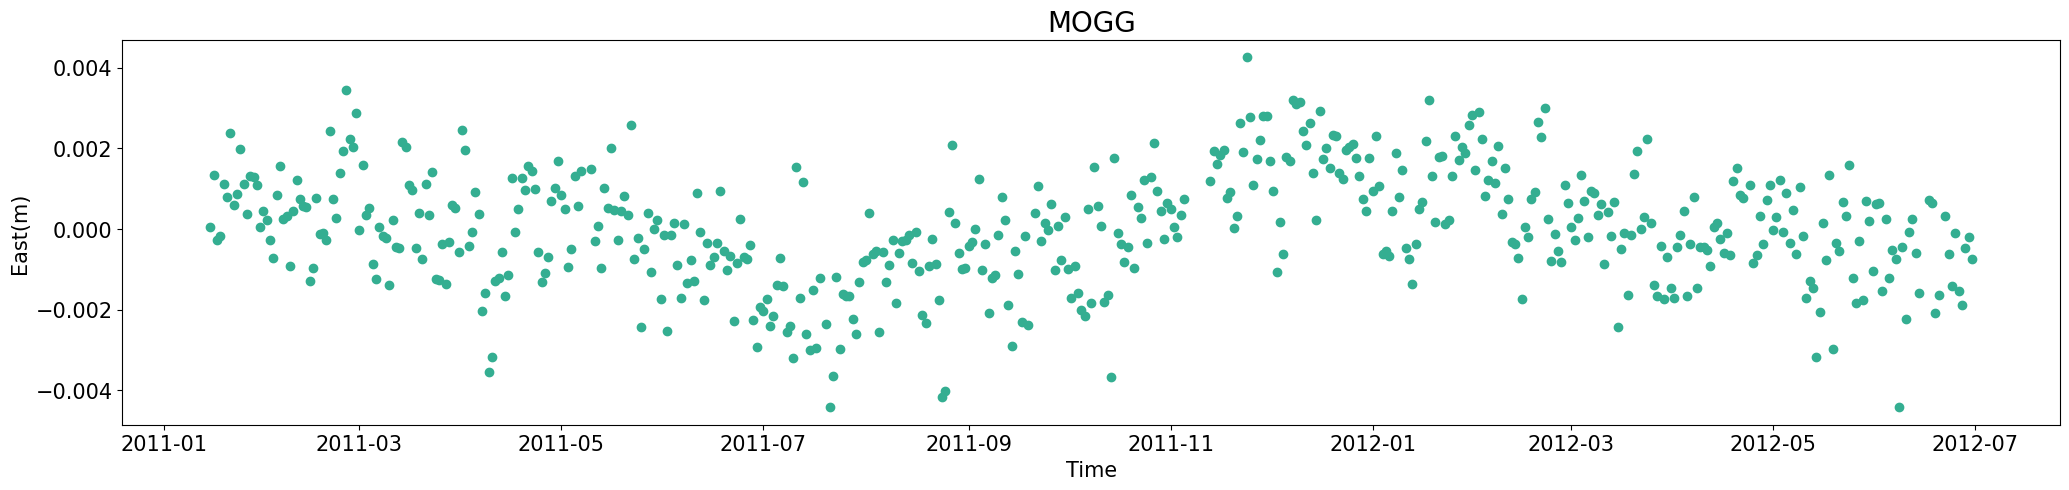

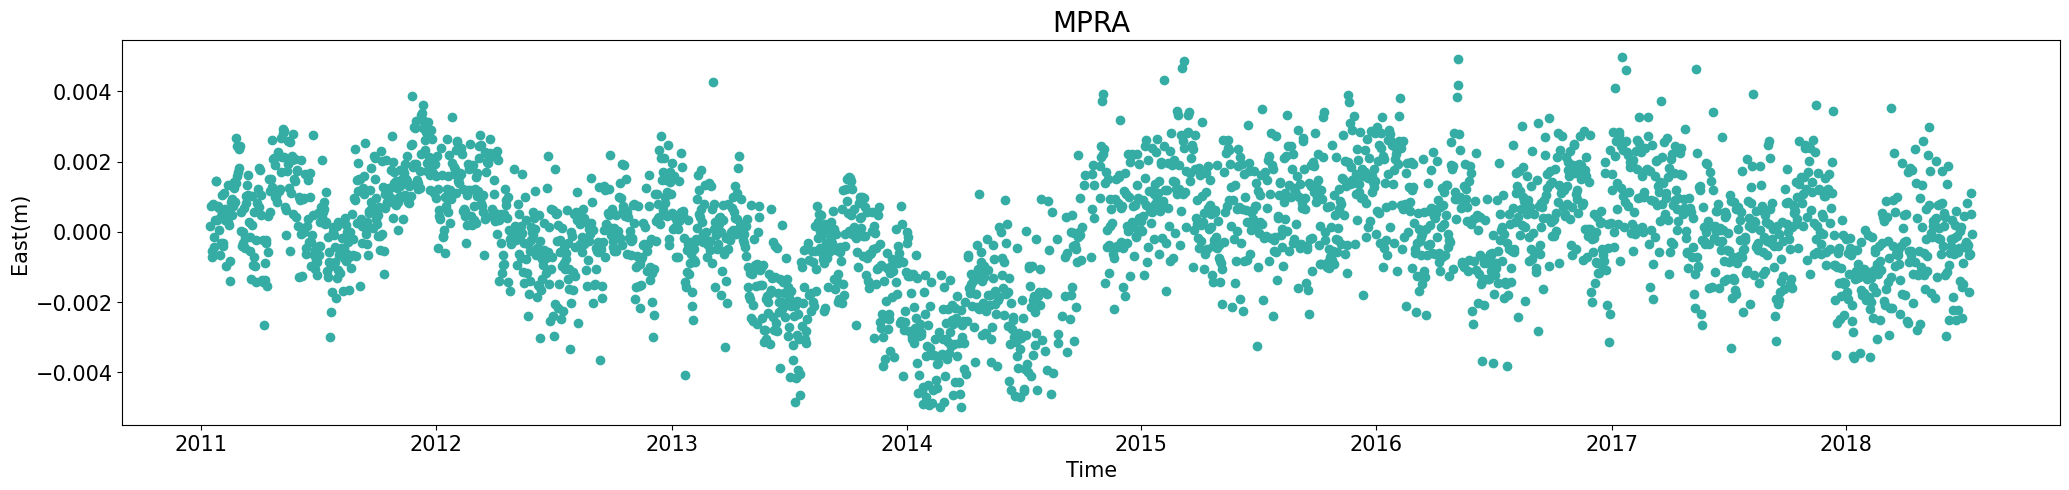

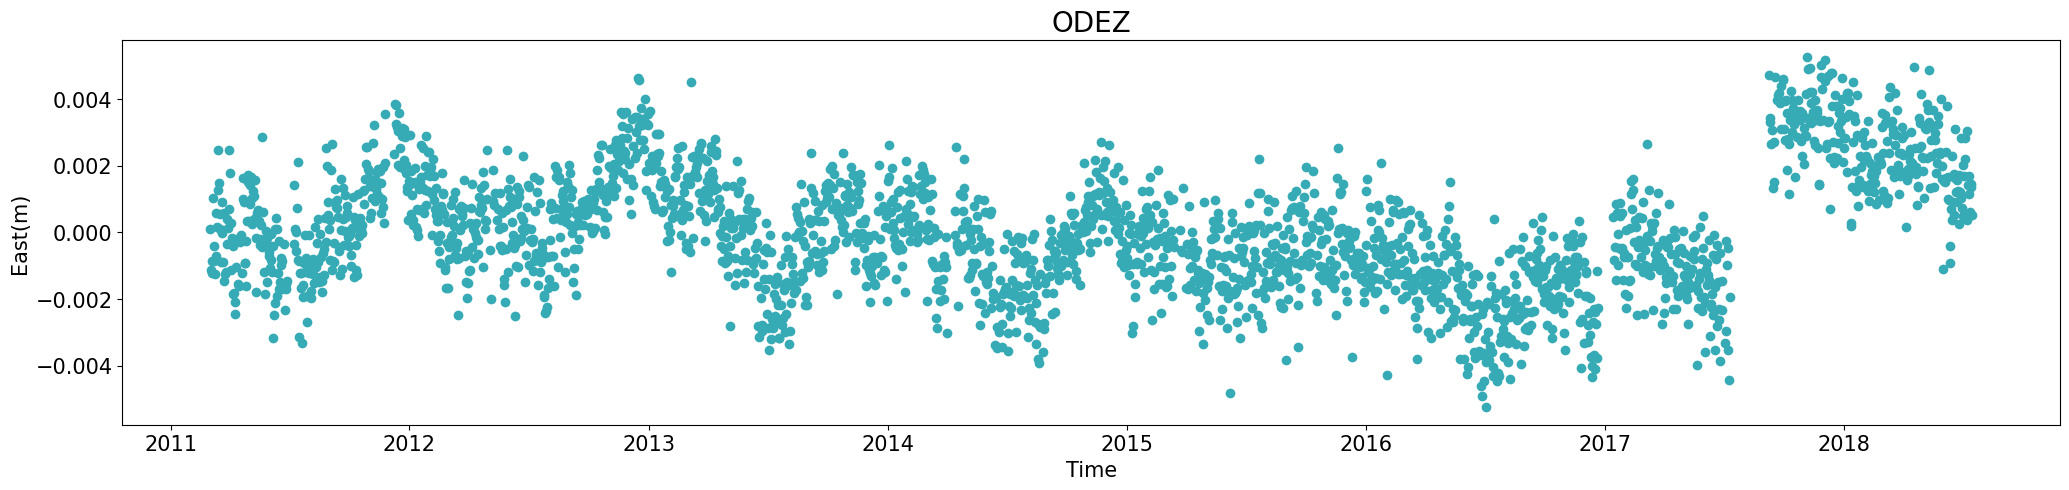

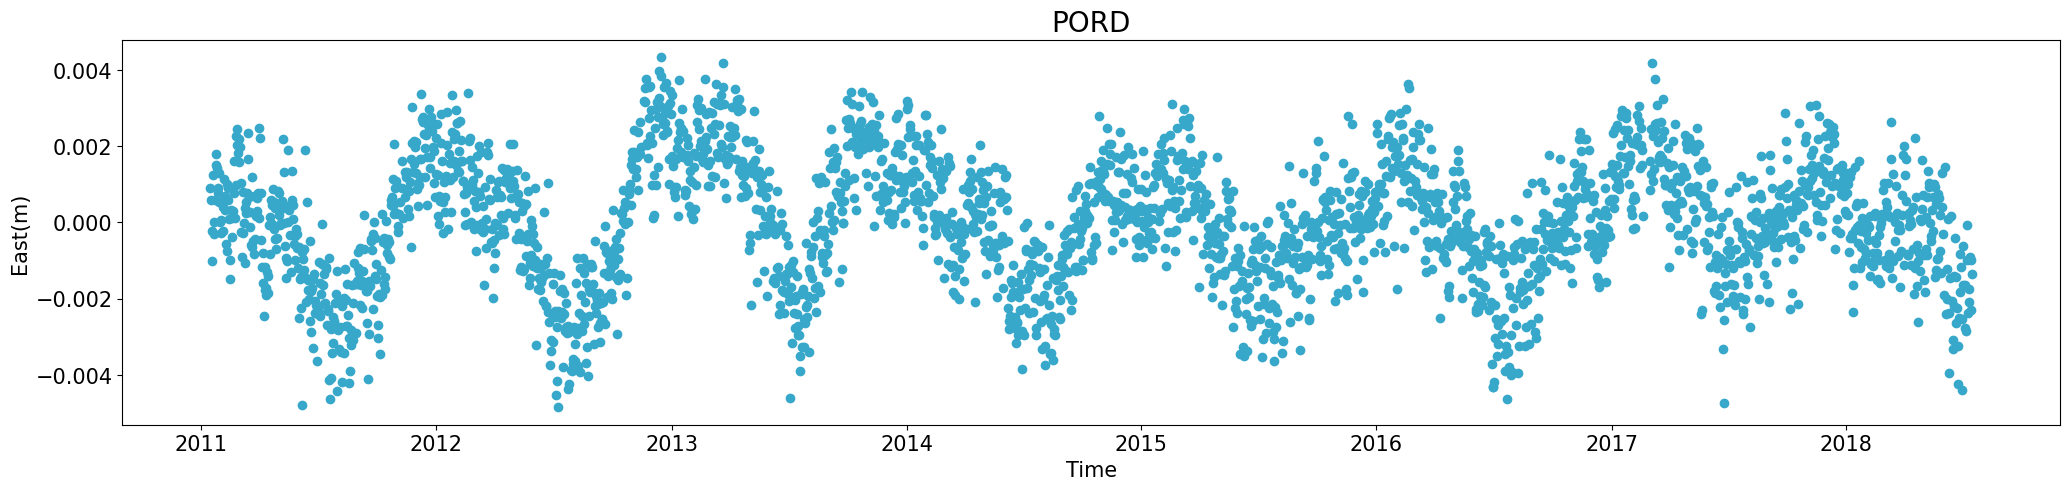

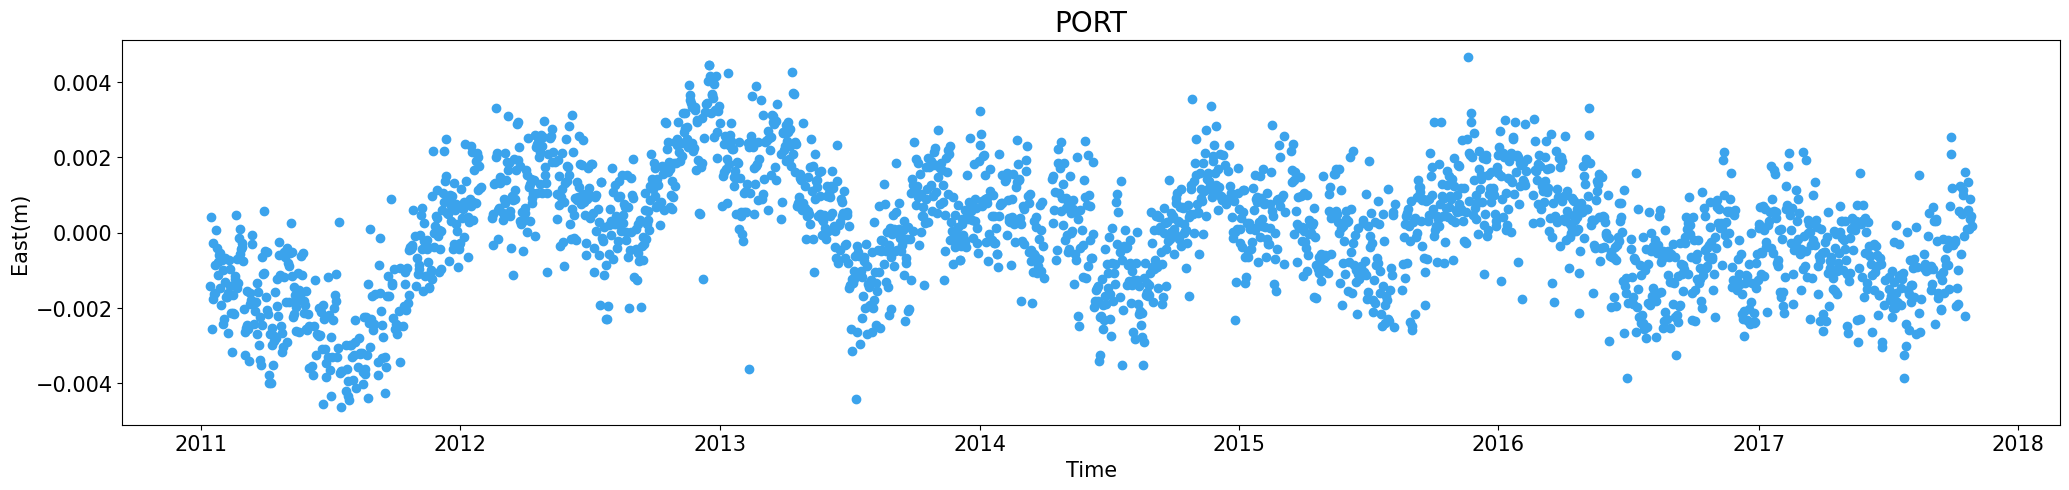

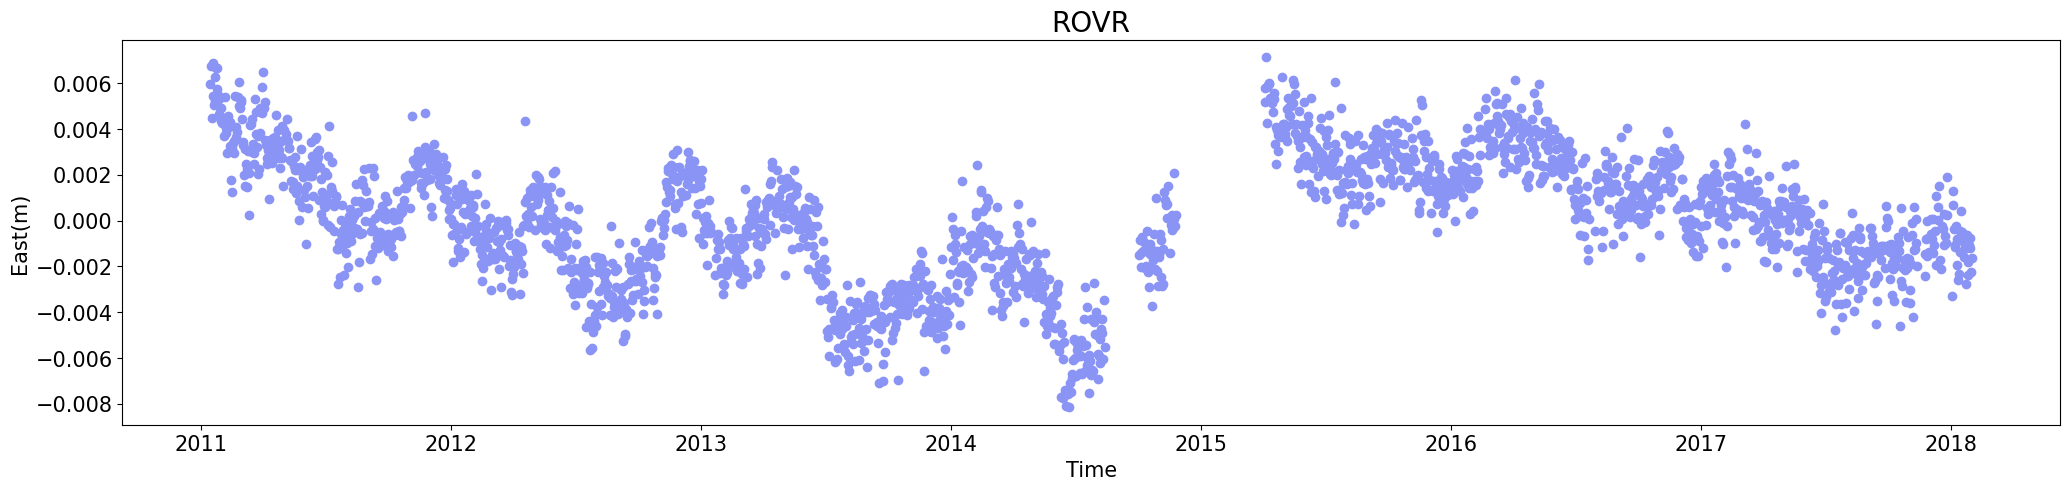

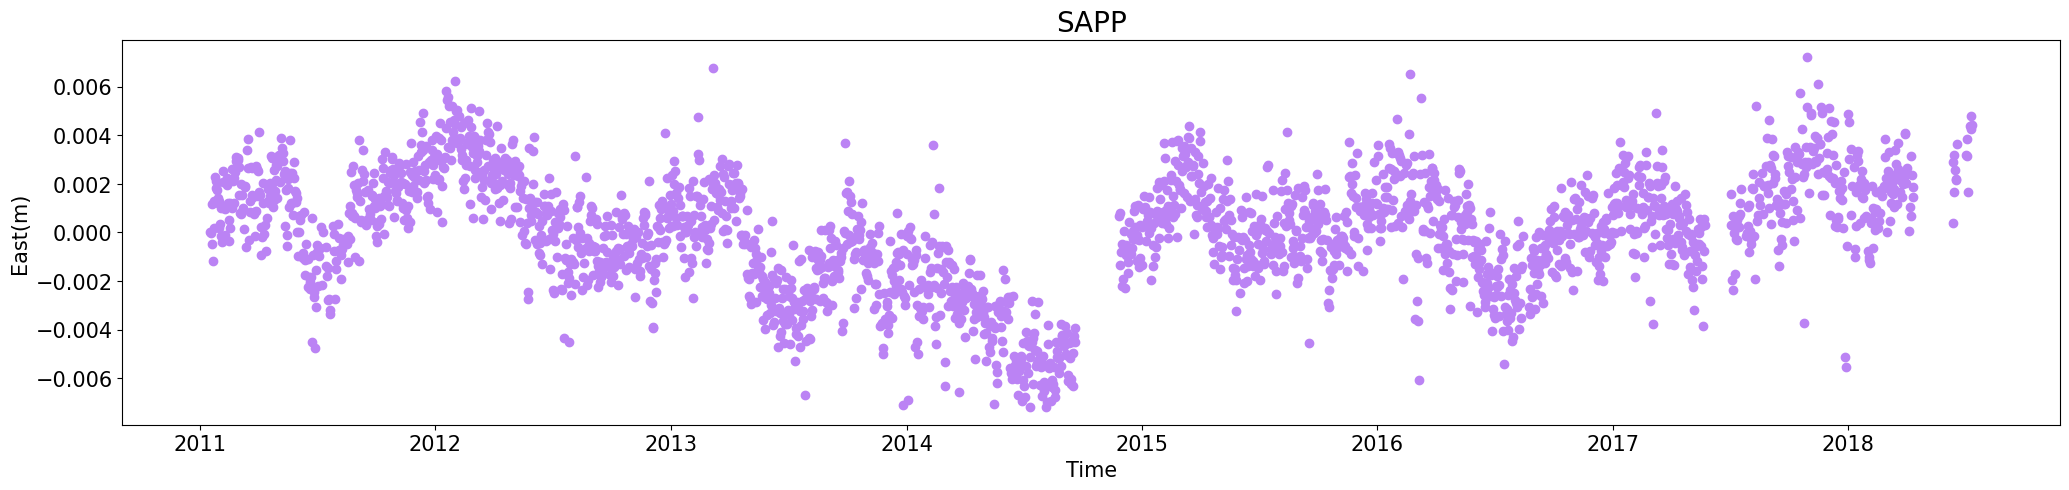

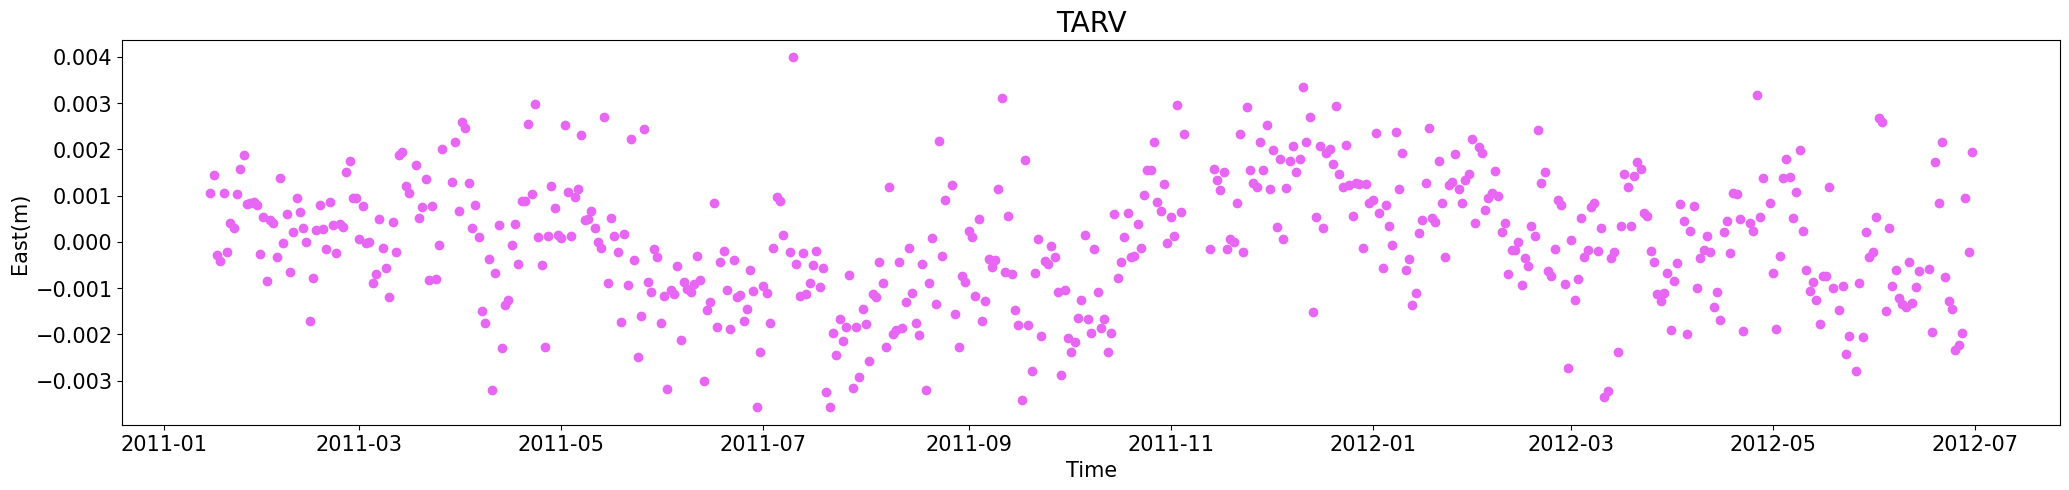

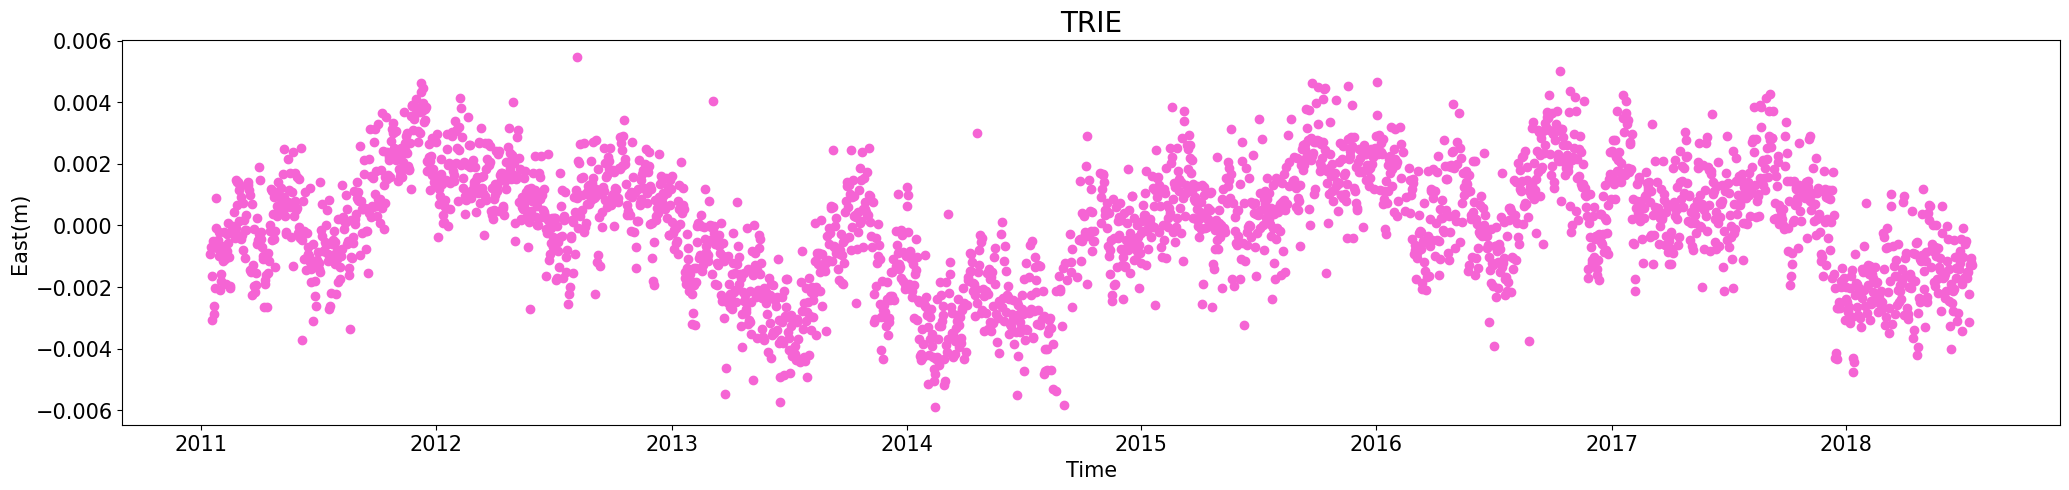

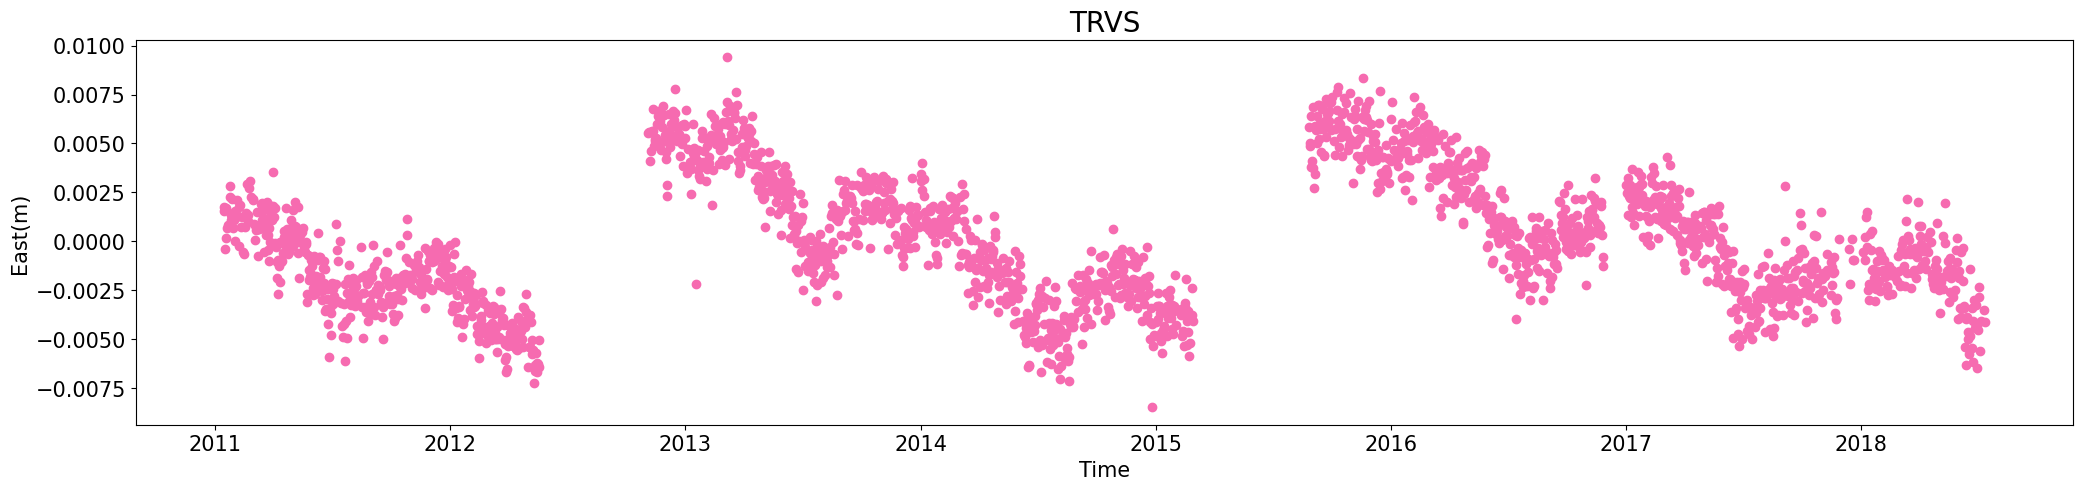

In [227]:
#checking the station's plots - serie detrended

colors = sns.color_palette("husl", len(stations_outliers_removed_dict))
folder = '/home/rafaela/internship/time_series/Time-Series-Analysis/Cansiglio Plateau + Classical Karst/images/stations_detrended'

for i, (station_name, station_data) in enumerate(stations_outliers_removed_dict.items()):
    plt.figure(figsize=(25, 5))
    
    plt.plot(station_data.index, station_data, 'o', color = colors[i])
    plt.title(f'{station_name.upper()}', fontsize = 20)
    plt.xlabel('Time', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.ylabel('East(m)', fontsize = 15)
    plt.yticks(fontsize=15)
    #plt.ylim(-0.008,0.008)
   
    fl = os.path.join(folder, f'{station_name}.svg')
    f = io.BytesIO()
    plt.savefig(fl, format="svg")

    plt.show()

In [220]:
def get_rolling_mean(station_data, station_name):
    
    station_rolling_mean = station_data.rolling(7, min_periods=1).mean()
    
    stations_rolling_mean_dataframe = pd.DataFrame(station_rolling_mean, 
                                              index=station_data.index)
    
    stations_rolling_mean_dataframe = stations_rolling_mean_dataframe.rename(
        columns={f'{station_name}_east(m)':f'{station_name}_east(m)_rm'})
    
    stations_rolling_mean_dataframe.dropna(inplace=True)
    
    return stations_rolling_mean_dataframe

#dictionaries to store the data
stations_rolling_mean_dict = {}

#calling the function
for station_name, station_data in stations_outliers_removed_dict.items():
    stations_rolling_mean_dataframe = get_rolling_mean(station_data, station_name)
    stations_rolling_mean_dict[station_name] = stations_rolling_mean_dataframe

#printing dataframe
#stations detrended
#for station_name, station_data in stations_rolling_mean_dict.items():
    #print(f'{station_name.upper()}: \n{station_data}\n')

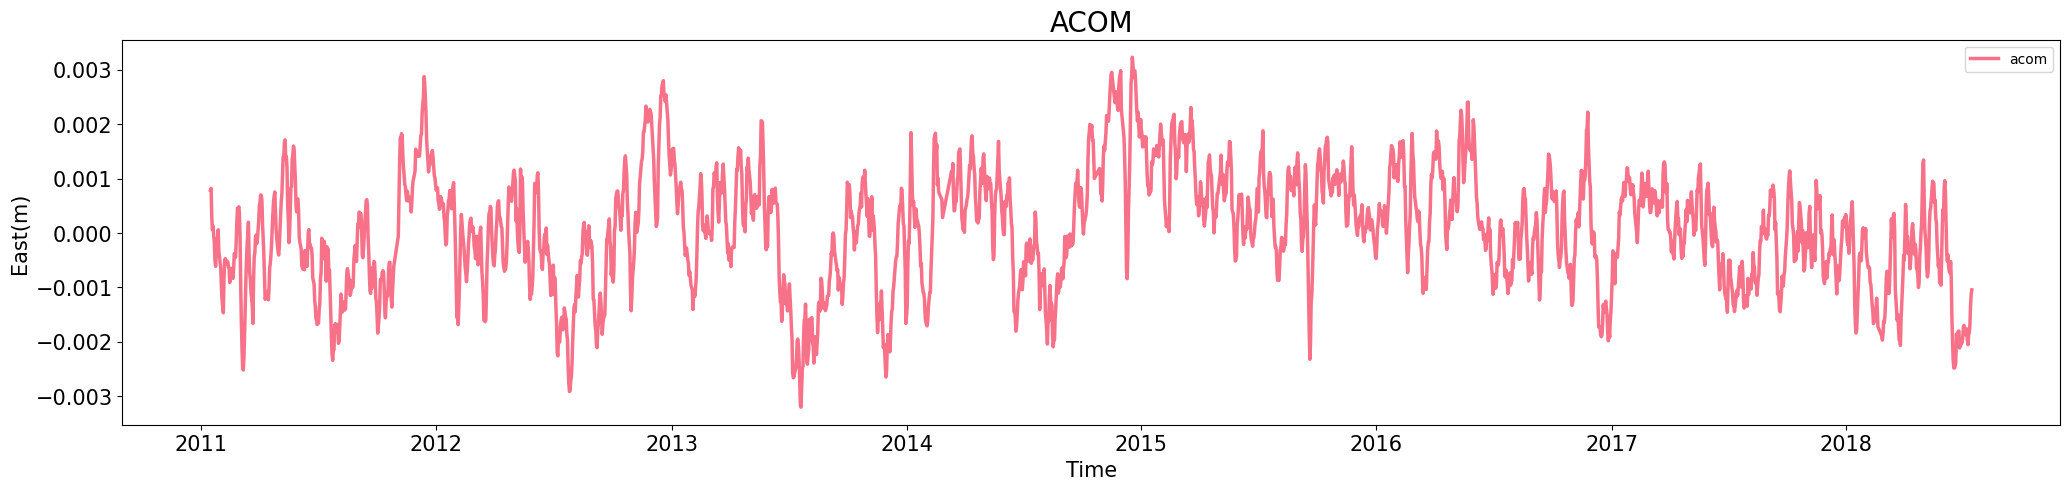

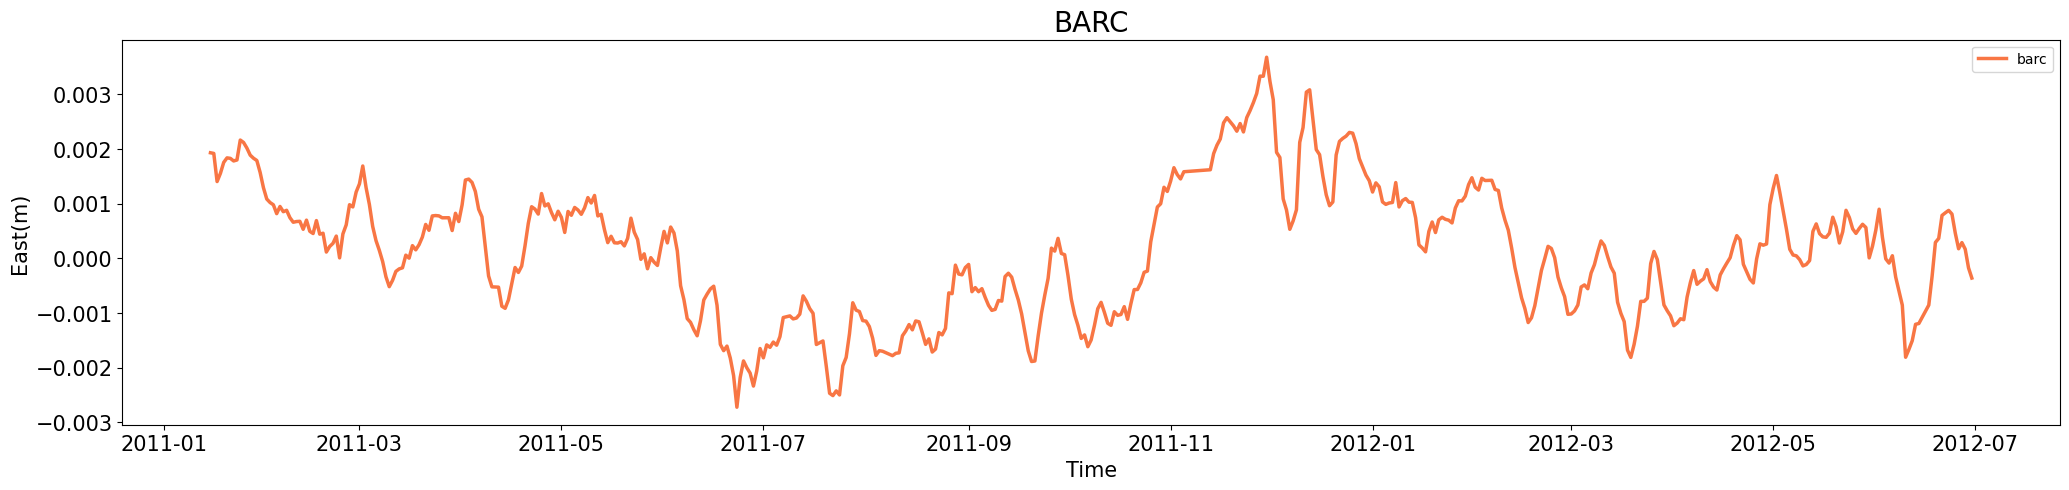

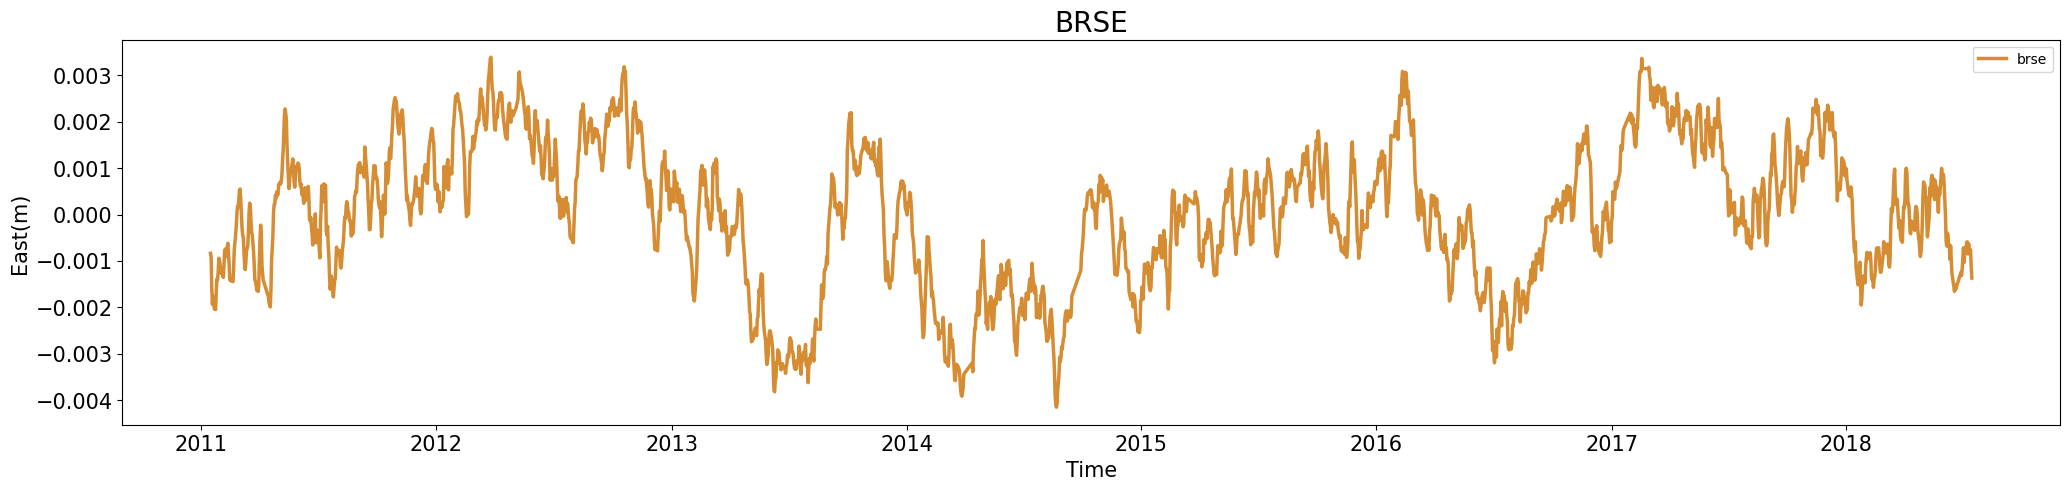

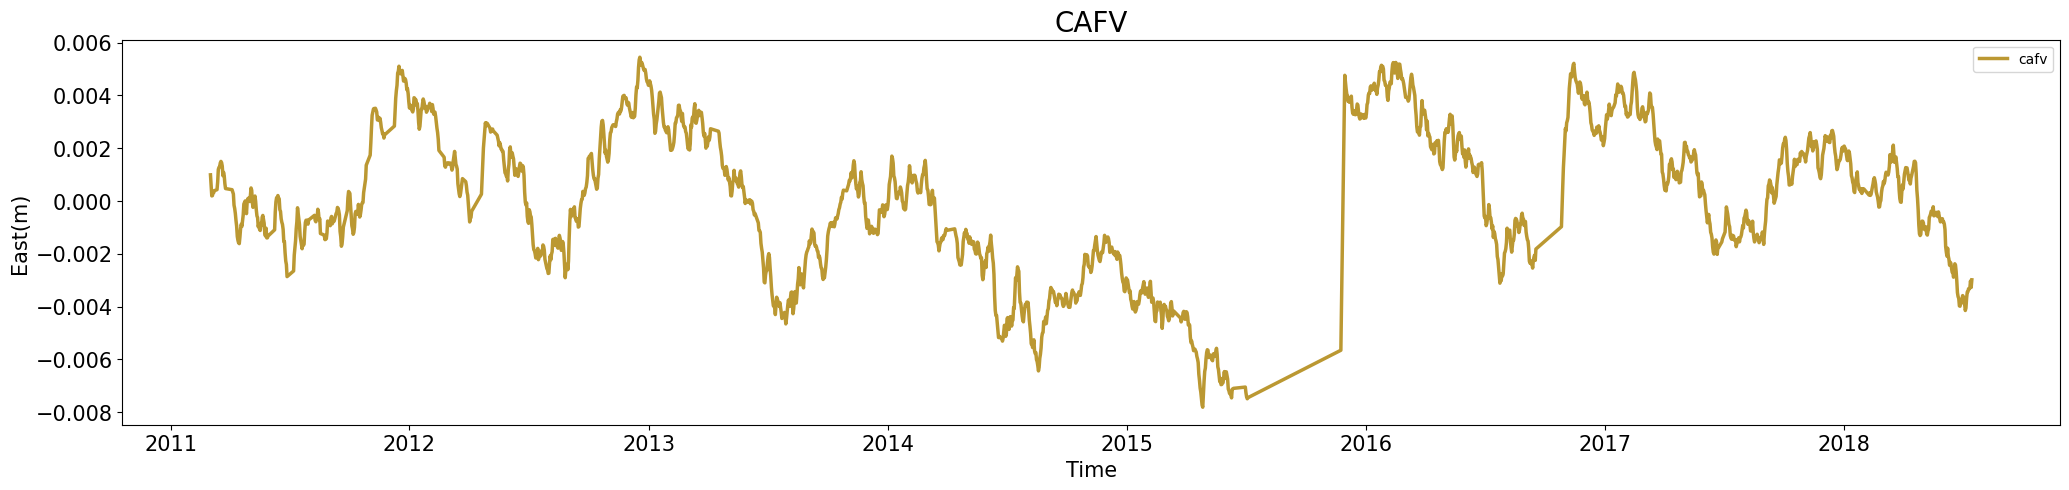

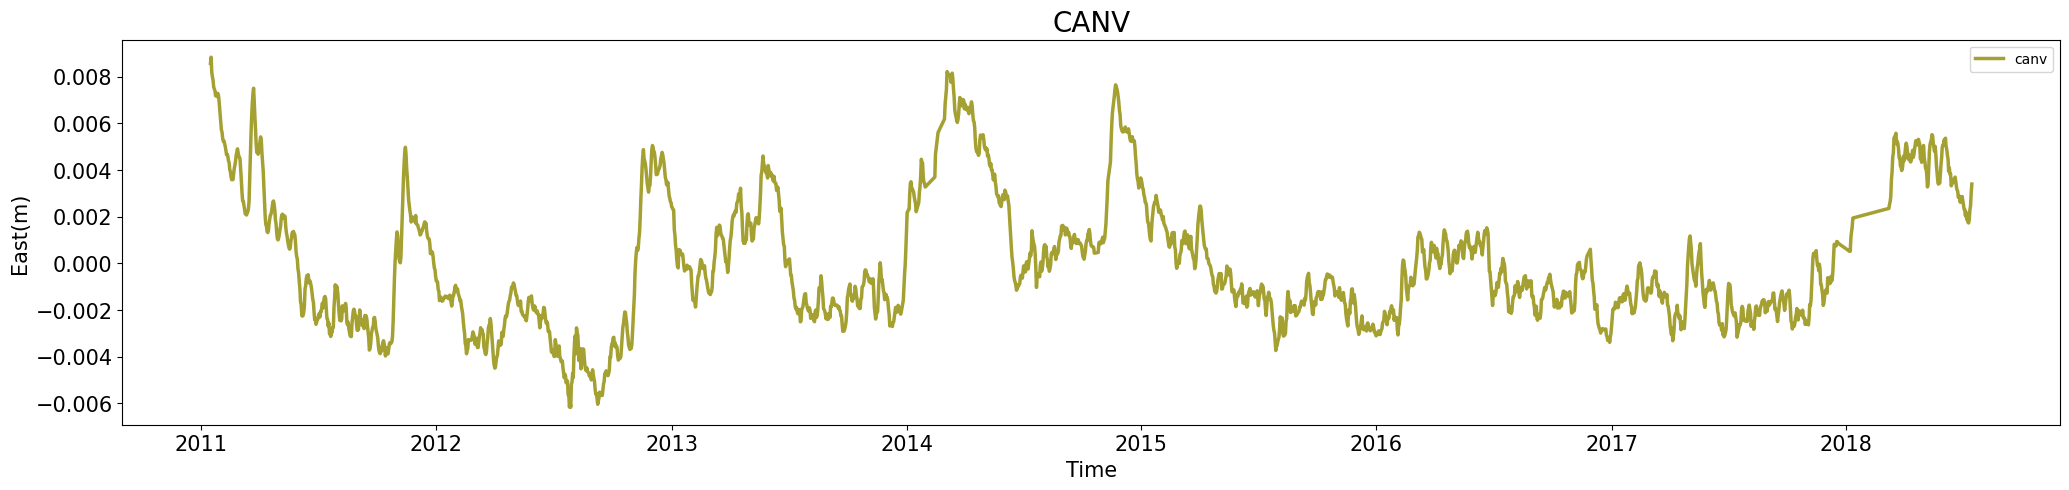

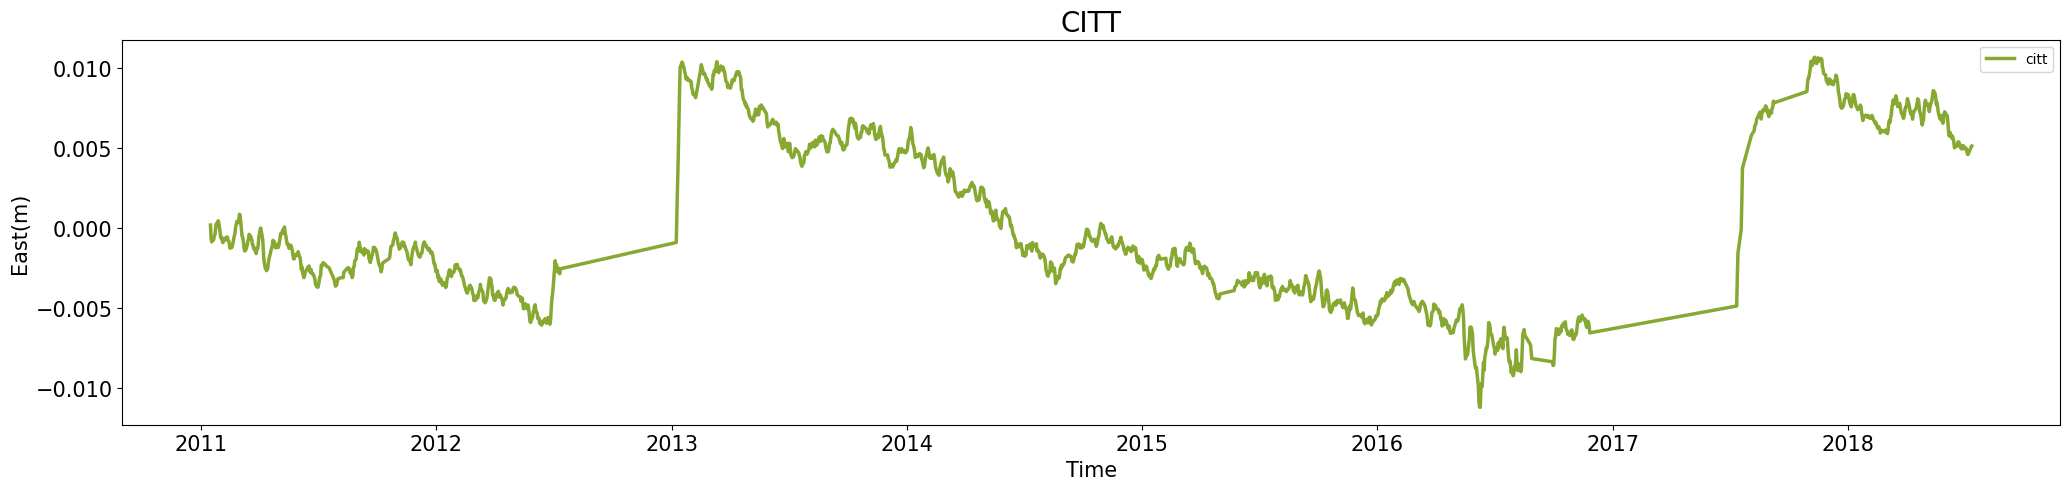

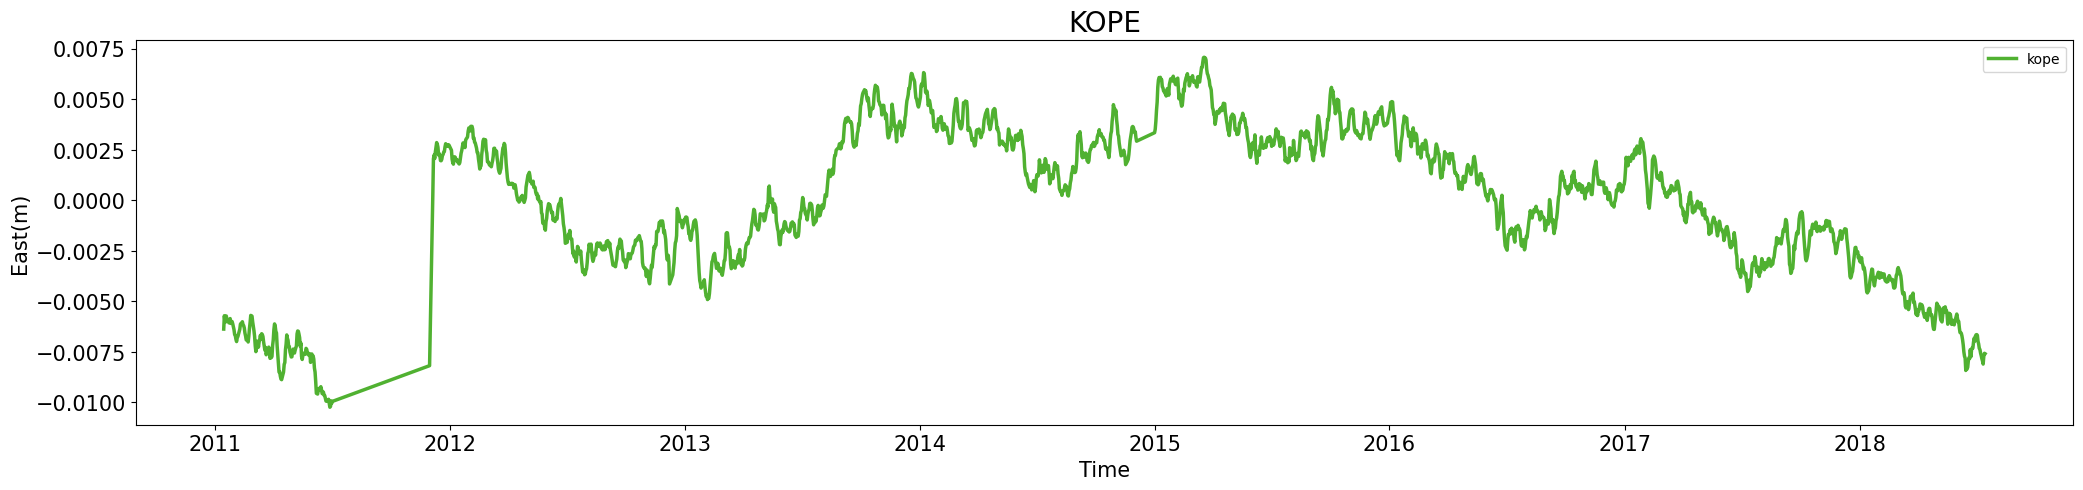

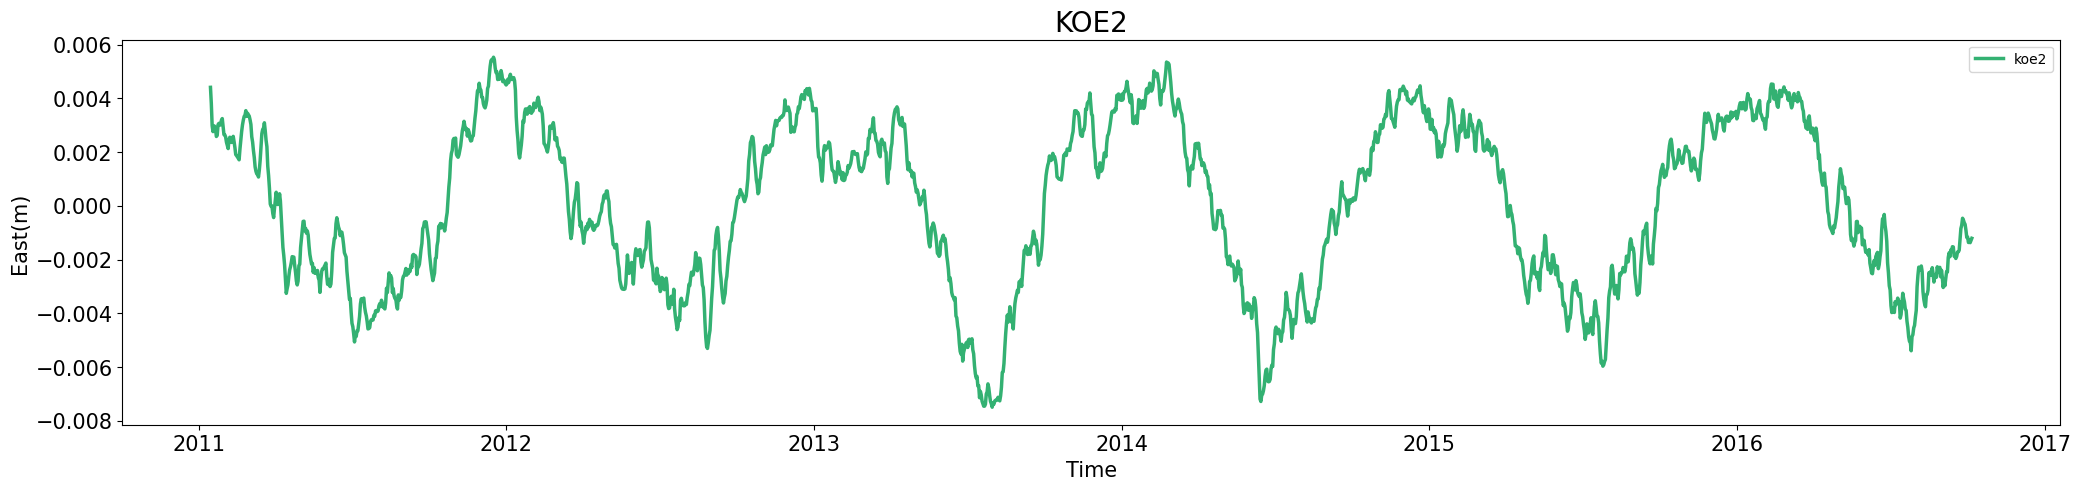

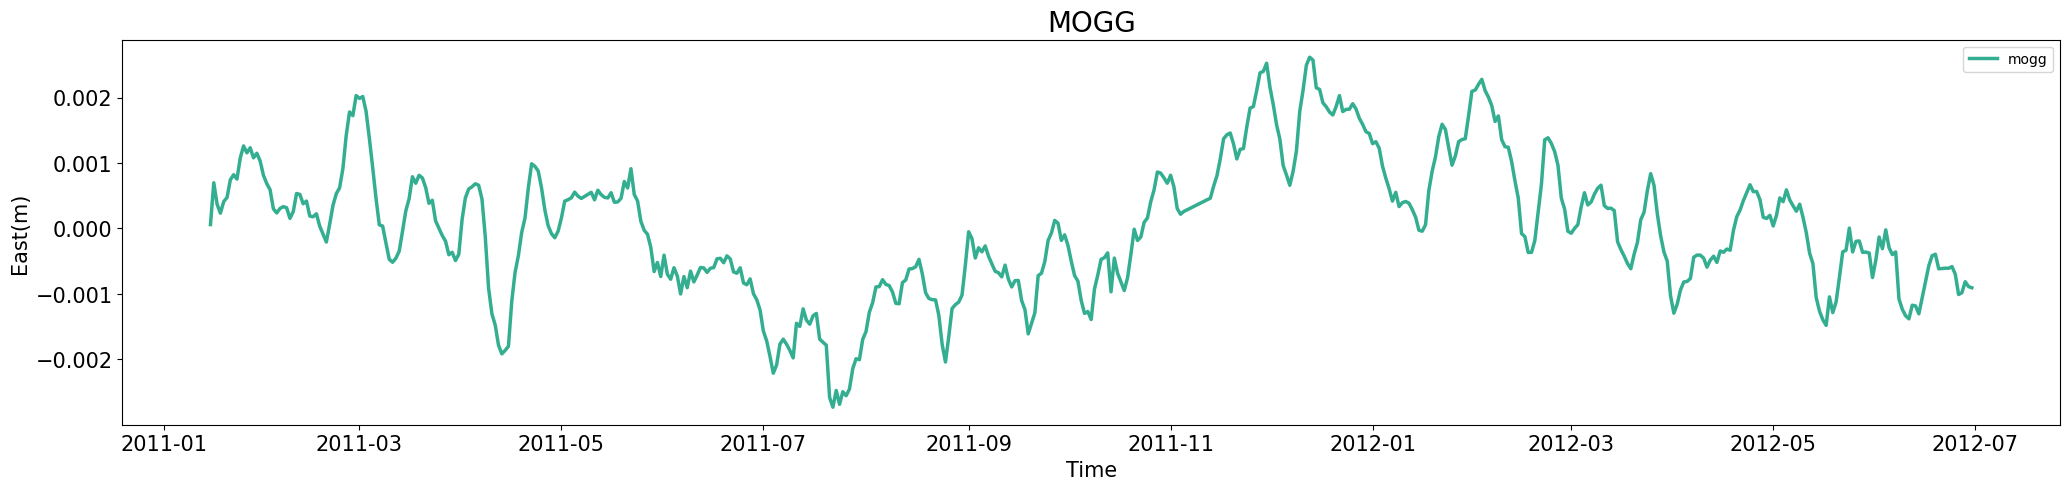

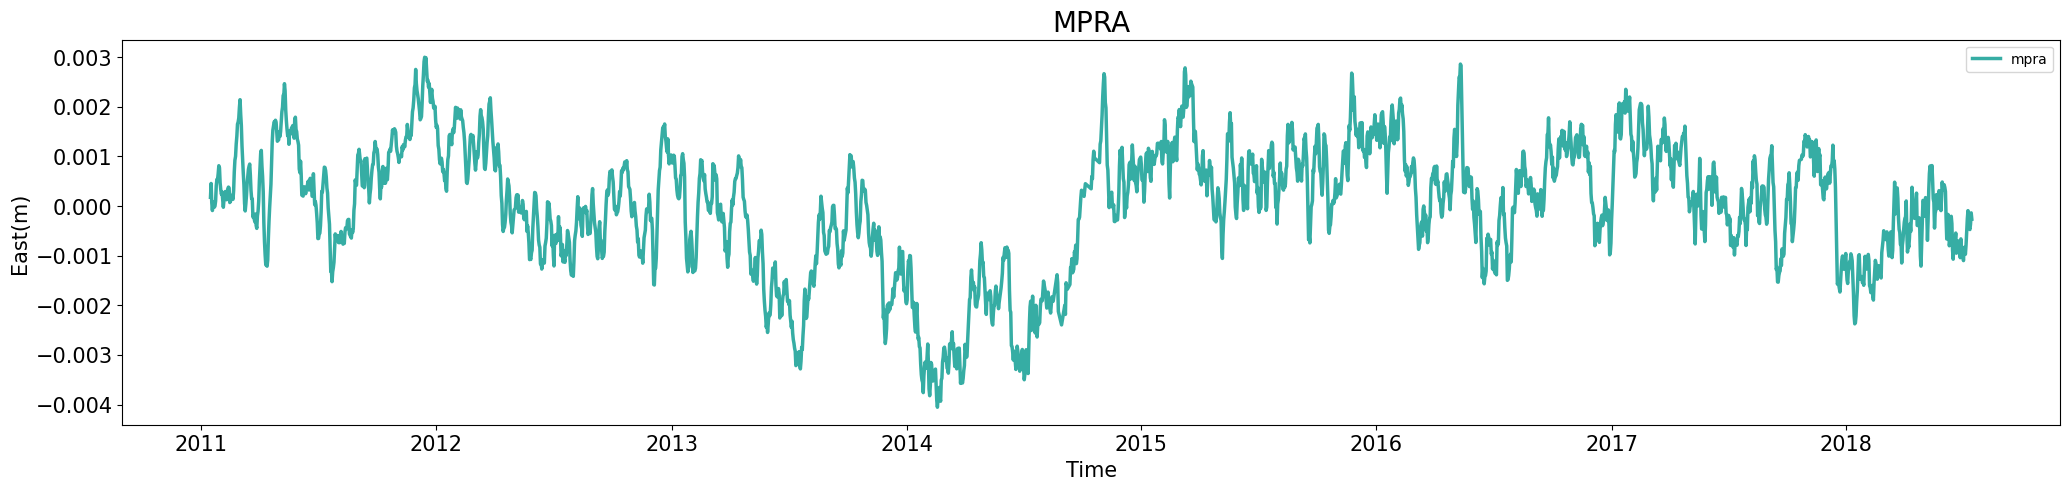

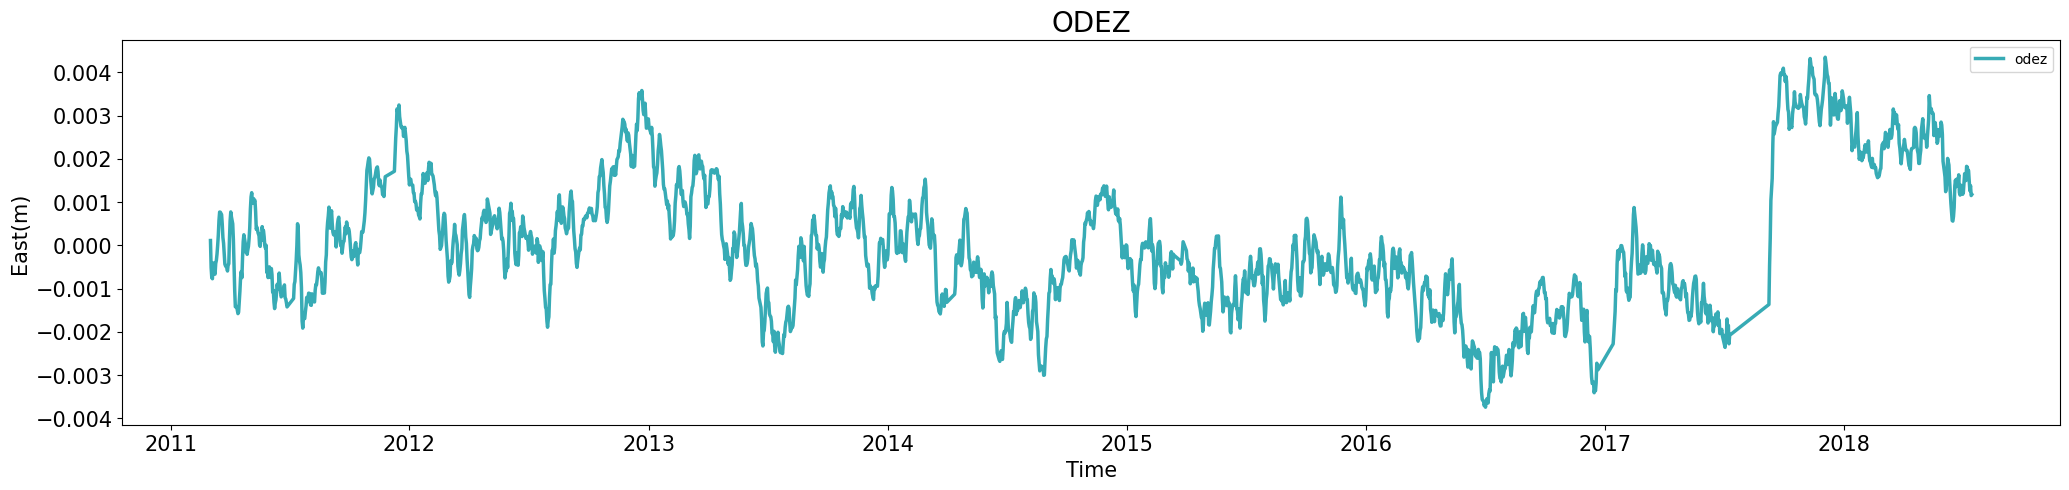

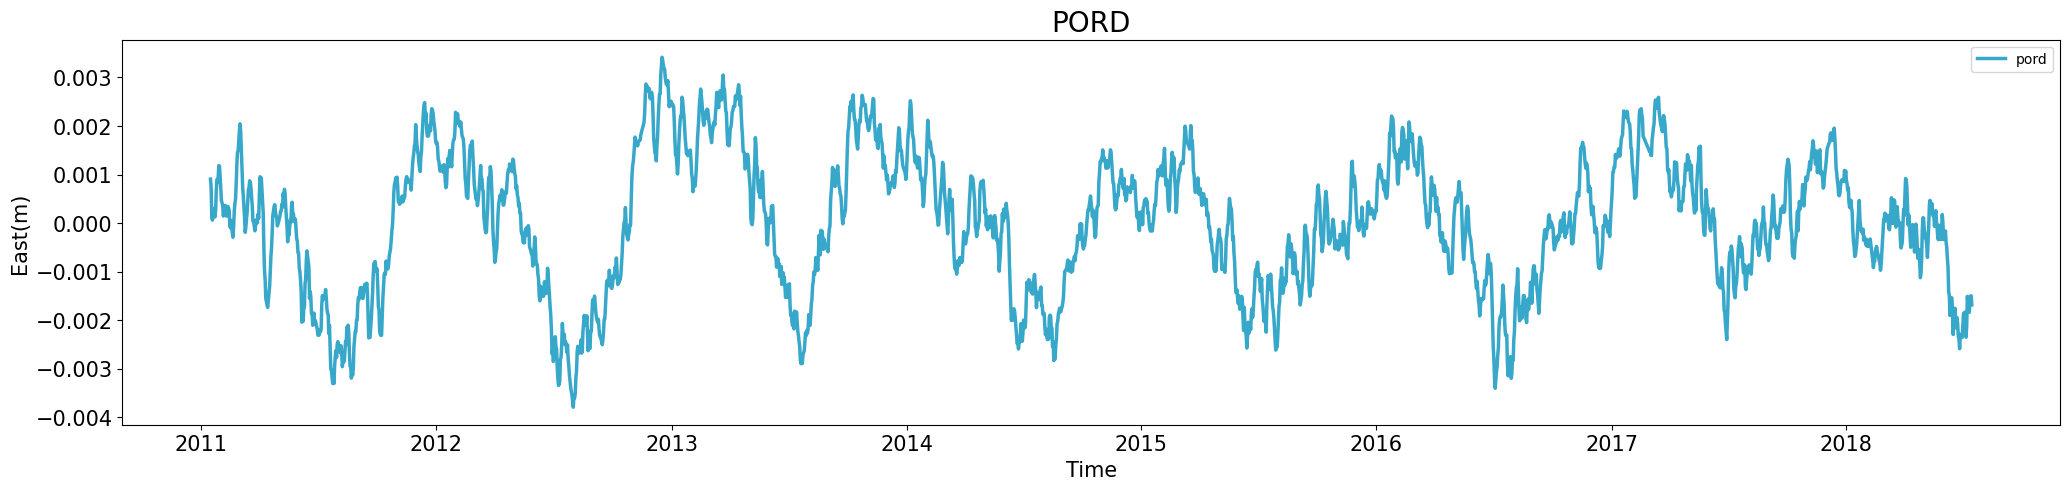

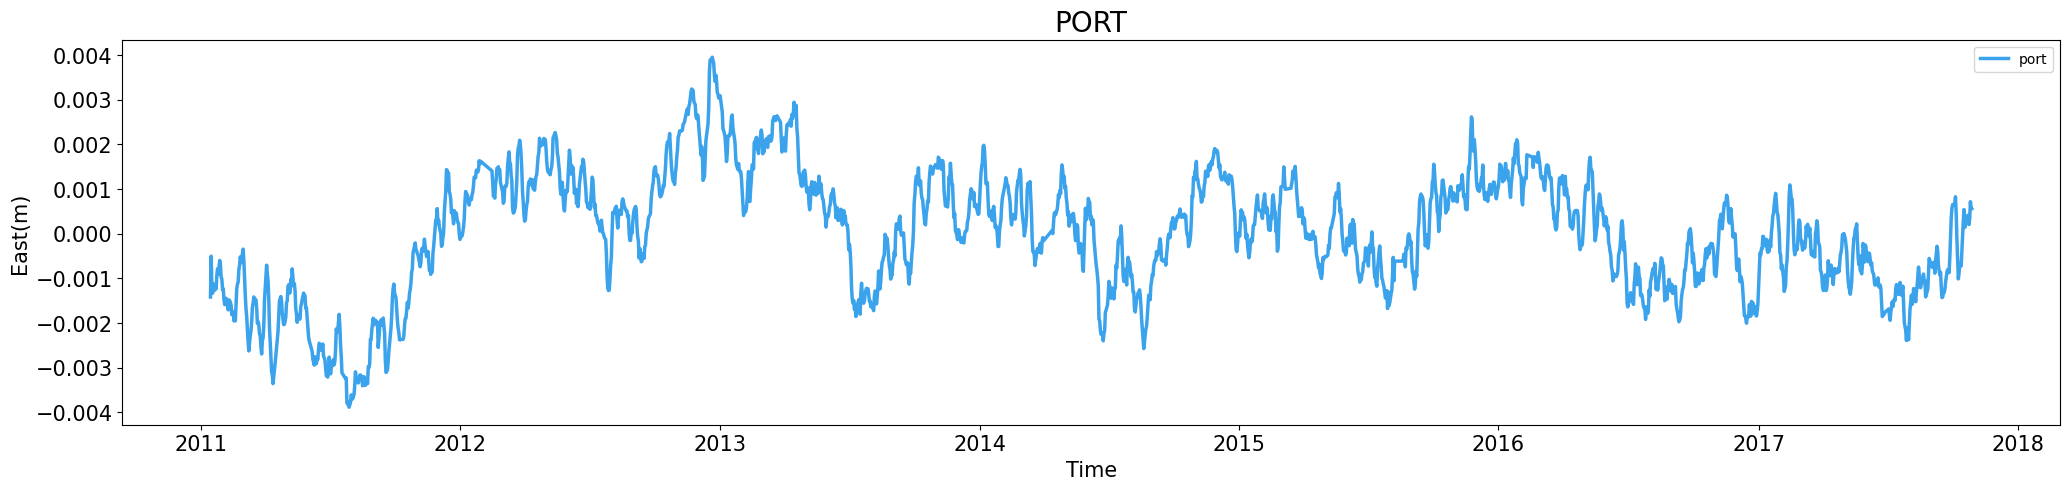

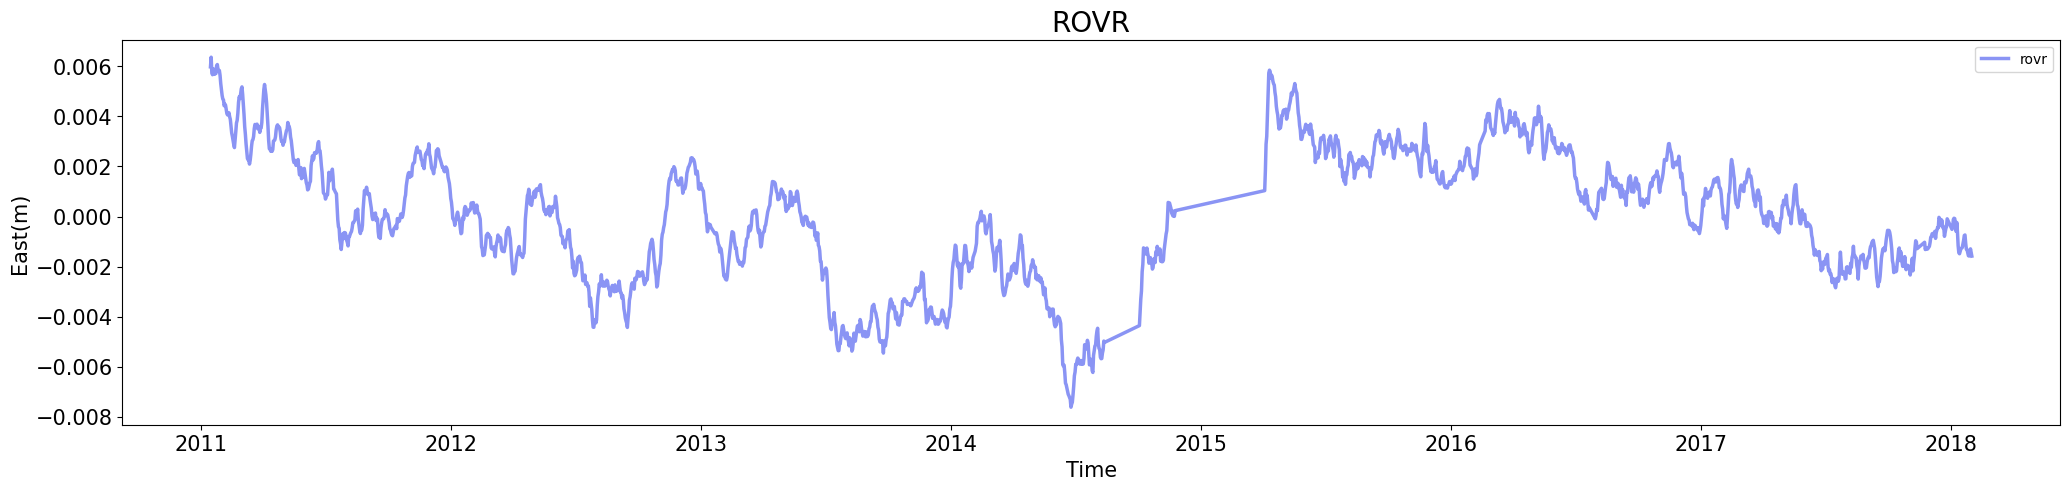

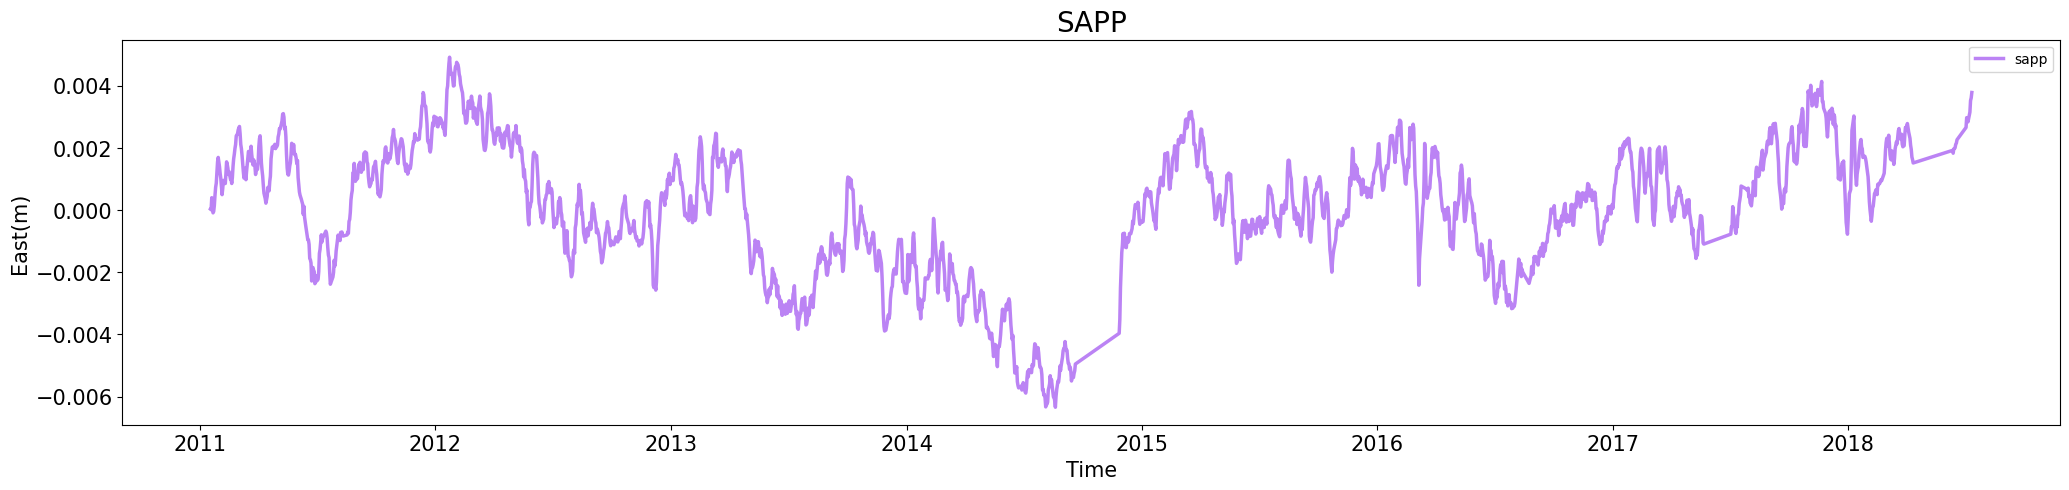

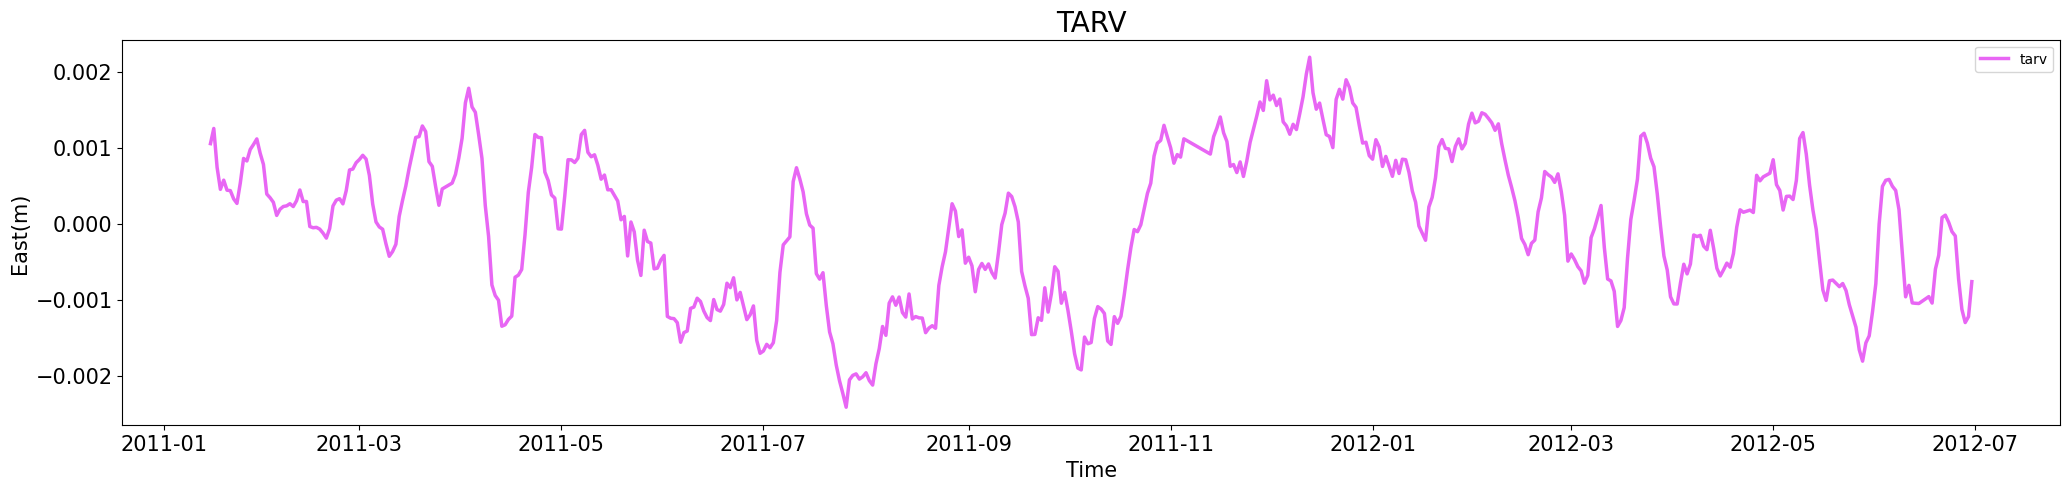

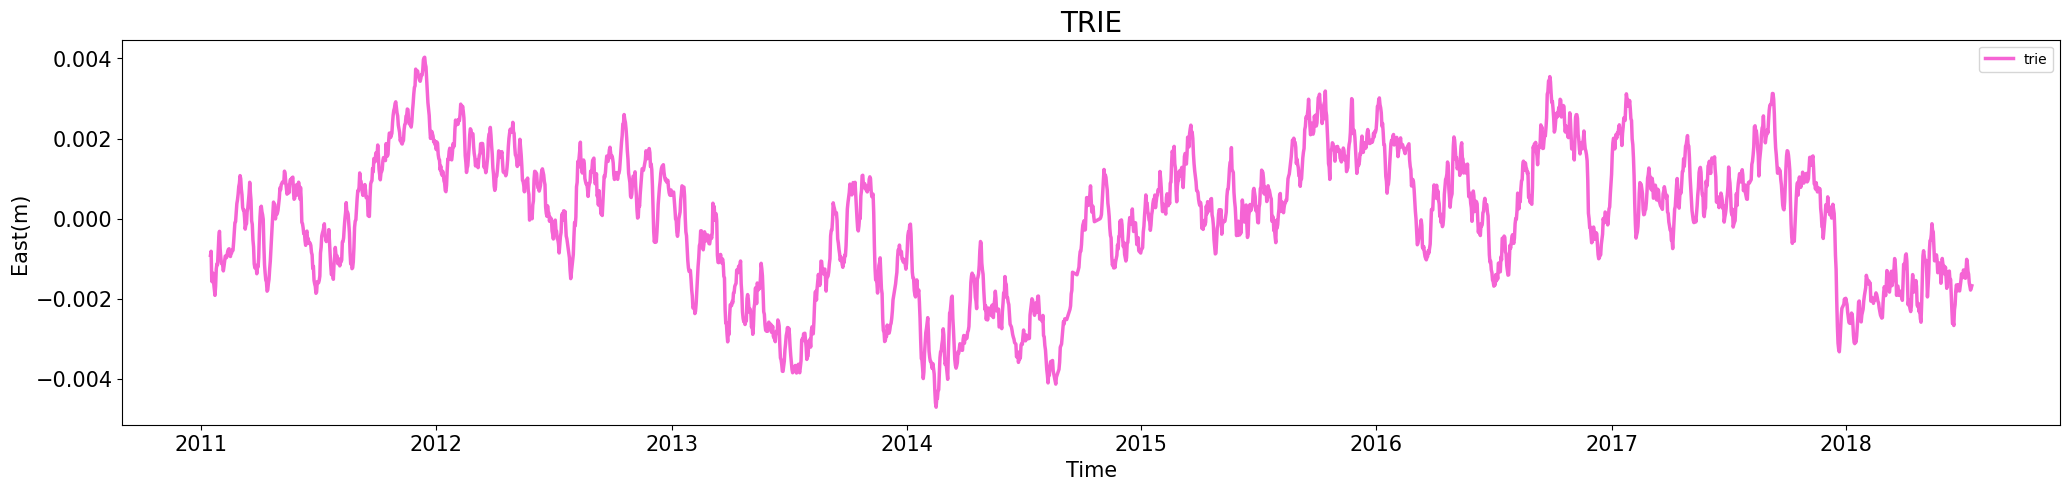

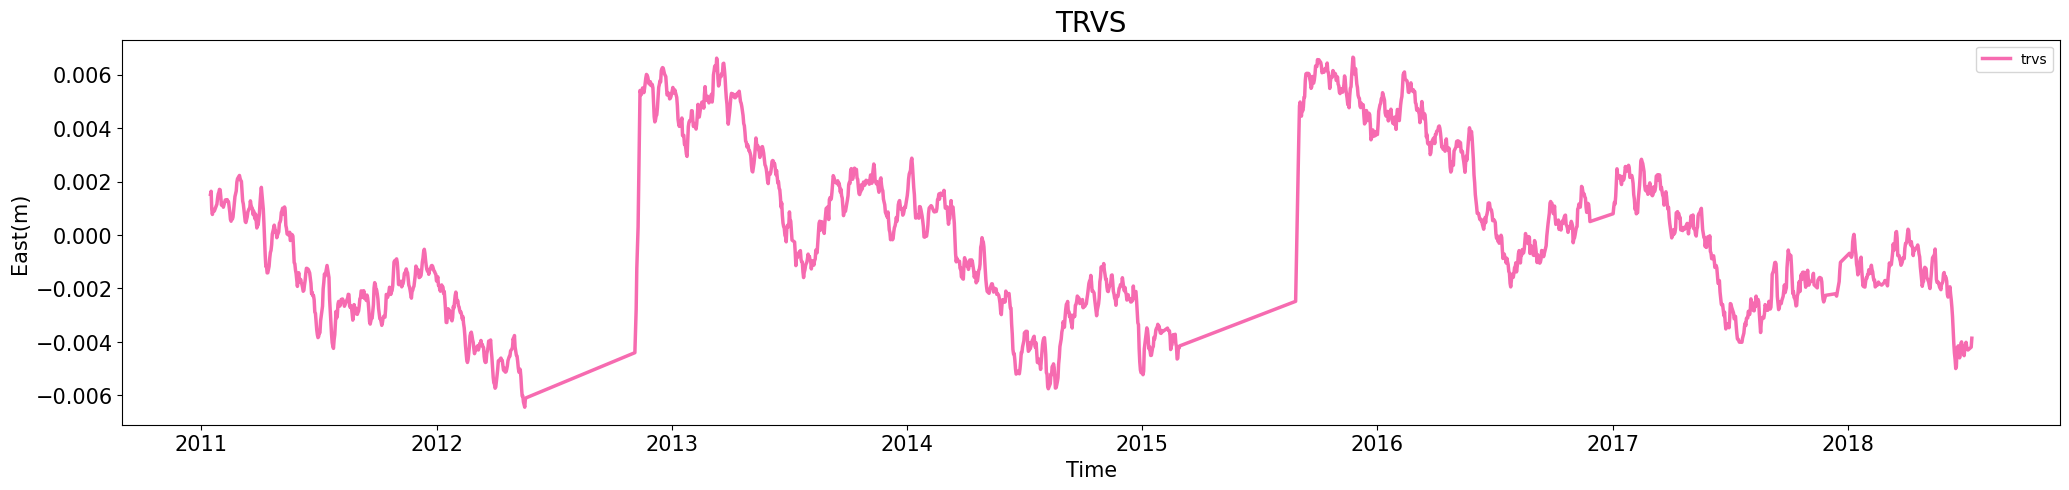

In [229]:
#checking the station's plots - serie's rolling mean

colors = sns.color_palette("husl", len(stations_outliers_removed_dict))
folder = '/home/rafaela/internship/time_series/Time-Series-Analysis/Cansiglio Plateau + Classical Karst/images/stations_rm'

for i, (station_name, station_data) in enumerate(stations_rolling_mean_dict.items()):
    plt.figure(figsize=(25, 5))
    
    plt.plot(station_data.index, station_data, label=f'{station_name}', color = colors[i], lw = 2.5)
    plt.title(f'{station_name.upper()}', fontsize = 20)
    plt.xlabel('Time', fontsize = 15)
    plt.xticks(fontsize=15)
    plt.ylabel('East(m)', fontsize = 15)
    plt.yticks(fontsize=15)
    #plt.ylim(-0.008,0.008)
    plt.legend()
    
    fl = os.path.join(folder, f'{station_name}.svg')
    f = io.BytesIO()
    plt.savefig(fl, format="svg")

    plt.show()